# Churn prediction model - telecommunication company

**Project description**
A telecommunication company 'TeleCat' wants to know how to predict the customers outflow. To boost customer retentions for such cases it would offer them promo codes and other special conditions. The company's team collected personal data about some customers, as well as the information about the tariffs and contracts they use.

'TeleCat' provides two main types of services:

1. A fixed line telephone connection.
2. Internet connection of two types: via DSL or fiber optic cable.

The following services are also available:

- Internet security: antivirus and harmful websites blocking;
- Dedicated customer support line;
- Data backup cloud storage;
- TV and movie streaming.

Clients can pay for services every month or sign a contract for 1-2 years. Various payment methods and the possibility of receiving an electronic check are available.

**Problem understanding** 
'TeleCat' company has high churn rate and wants to be able to predict customer behaviour in terms of leaving intention

**Project goal** 
Build a model, able to predict customer churn behaviour with ROC AUC score not less than 0.85. 

**Data**
    
The data consists of the following files:
- `contract.csv` - contracts information;
- `personal.csv` - clients personal data;
- `internet.csv` - information about Internet services;
- `phone.csv` - information about telephone services.
Information about contracts is accurate as of February 1, 2020.


**Project content**

- Data loading and preliminary data observation
- Definition of more **elaborate plan**
- Data preprocessing and Exploratory data analysis
- Modeling
- Results communication

## Data loading and preliminary data observation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from skimpy import clean_columns

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier


C:\Users\dashu\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
#Data loading

list_of_names = ['contract','personal','internet','phone']
 
dataframes_list = []
 
for i in range(len(list_of_names)):
    try:
        temp_df = pd.read_csv('/datasets/final_provider/'+list_of_names[i]+'.csv')
    except:
        temp_df = pd.read_csv('./'+ list_of_names[i]+'.csv')   
    temp_df.name=list_of_names[i]
    dataframes_list.append(temp_df)
 

In [3]:
#Datasets renaming

contract = dataframes_list[0]
personal = dataframes_list[1]
internet = dataframes_list[2]
phone = dataframes_list[3]   

In [4]:
for data in [contract, internet, personal, phone]:
    print('\n\033[1m' + f'Information about dataset {data.name}' + '\n')
    print('First 5 rows:' + '\033[0m')
    display(data.head())
    print('\n\033[1m' + 'General info:\n' + '\033[0m')
    data.info()
    print('\n\033[1m' + 'Descriptive statistics:\n' + '\033[0m')
    display(data.describe(include='all'))
    print('\n\033[1m' + 'Number of duplicates:\n' + '\033[0m')
    display(data.duplicated().sum())
    print('\n\033[1m' + 'Missing values:\n' + '\033[0m')
    display(data.isna().sum())
    print('__________________________________')


Information about dataset contract

First 5 rows:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65



General info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

Descriptive statistics:



,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,5,3,2,4,NaN,6531
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5174,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN



Number of duplicates:



0


Missing values:



customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

__________________________________

Information about dataset internet

First 5 rows:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



General info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB

Descriptive statistics:



,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785



Number of duplicates:



0


Missing values:



customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

__________________________________

Information about dataset personal

First 5 rows:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



General info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

Descriptive statistics:



,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,7590-VHVEG,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN



Number of duplicates:



0


Missing values:



customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

__________________________________

Information about dataset phone

First 5 rows:


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



General info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB

Descriptive statistics:



,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390



Number of duplicates:



0


Missing values:



customerID       0
MultipleLines    0
dtype: int64

__________________________________


**First insights for data preprocessing**

- No missing data and duplicates;
- Columns names should be brought to snake_case;
- 'BeginDate' column type should be changed to datetime;
- It's evident that the **target variable** can be found in the column **'EndDate'** of the 'contract' dataset. To be checked whether it contains some values different from 'No' or the data of the contract closure;
- Strangely, 'TotalCharges' column is of object type, whereas it has to be of a numberic type.
The rest of the data looks promising.

In [5]:
#bringing columns' names to snake_case
contract = clean_columns(contract)
internet = clean_columns(internet)
personal = clean_columns(personal)
phone = clean_columns(phone) 

8 column names have been cleaned

8 column names have been cleaned

4 column names have been cleaned

2 column names have been cleaned

In [6]:
#begin_date to datetime type
contract['begin_date'] = pd.to_datetime(contract['begin_date'], format='%Y-%m-%d')

In [7]:
# values check in target feature column - end_date 
print('Column end_date:')
no_values = len(contract[contract['end_date'] == 'No' ])
print('"No" Values:', no_values)
datetime_values = len(pd.to_datetime(contract[contract['end_date'] != 'No' ]['end_date'], format='%Y-%m-%d %H:%M:%S'))
print('Datetime values:', datetime_values)

if no_values + datetime_values == len(contract):
    print('No alternative values')

Column end_date:
"No" Values: 5174
Datetime values: 1869
No alternative values


In [8]:
#total_charges column check 
errors = []

for i in range(len(contract)):
    try:
        float(contract['total_charges'][i])
    except ValueError:
        errors.append(i)
        
print(contract.iloc[errors])
len(errors)

     customer_id begin_date end_date      type paperless_billing  \
488   4472-LVYGI 2020-02-01       No  Two year               Yes   
753   3115-CZMZD 2020-02-01       No  Two year                No   
936   5709-LVOEQ 2020-02-01       No  Two year                No   
1082  4367-NUYAO 2020-02-01       No  Two year                No   
1340  1371-DWPAZ 2020-02-01       No  Two year                No   
3331  7644-OMVMY 2020-02-01       No  Two year                No   
3826  3213-VVOLG 2020-02-01       No  Two year                No   
4380  2520-SGTTA 2020-02-01       No  Two year                No   
5218  2923-ARZLG 2020-02-01       No  One year               Yes   
6670  4075-WKNIU 2020-02-01       No  Two year                No   
6754  2775-SEFEE 2020-02-01       No  Two year               Yes   

                 payment_method  monthly_charges total_charges  
488   Bank transfer (automatic)            52.55                
753                Mailed check            20.25     

11

There are only 11 rows with missing values in total_charges. Given that the begin_date of these contracts is same as the date of data extraction provided by the customer, we can assume that the information about these clients is not representable enough to be relevant for our future model, since they haven't used the services yet. 
Therefore we can remove these rows from the dataset and change the total_charges column to float.

In [9]:
contract = contract.loc[contract['total_charges'] != ' ']
contract = contract.astype({'total_charges': float})

In [10]:
print(contract.info())
print()
print(personal.info())
print()
print(internet.info())
print()
print(phone.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   object        
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 494.4+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 n

After initial data preprocessing we can say that we can work with 7032 'clean' entries in main dataset - 'contract'. Since other datasets contain less information it should be considered further during tables merge.
Another thing which can be noted is that not all the clients use both Internet and Phone service, which should be also taken into account as many values will be absent after the tables merge.

As it was already mentioned before target variable is the date of the contract closure. If equals to 'No', the customer is still with us, otherwise it shows the date when a customer left. This feature will be a key variable later for the modeling. 

## Definition of more **elaborate plan**

- Data loading and preliminary data observation **Done**
    - work on missing data, duplicates, data formating, data type conversion, etc.**Done**
    - target variable definition**Done**
- Definition of more **elaborate plan**
- Data preprocessing and Exploratory data analysis
    - dataframes merge and work with missing data
    - adding synthetic data if necessary
    - customers' personas analysis
    - multicollinearity study
    - unnecessary features elimination
- Modeling
    - train-test split (3:1)
    - choosing of several models and hyperparameters tuning
    - best model identification by AUC-ROC metrics
    - feature importance calculation
    - roc curve construction
    - best model testing on test sample
    - accuracy calculation and interpretation
    - best model comparison with Dummy model
- Results communication
    - checklist of initial plan
    - project obstacle analysis 
    - key steps for project goal acievement
    - best model, its quality and limitations

## Data preprocessing and Exploratory data analysis

Let's put target feature in a separate column - 'left'.
If equals 1, the customer has left, if equals 0, he's still with us.

In [11]:
#introducing a dedicated column for the target variable
def change_dtype(value):
    if value != 'No':
        value = '1'
    else: 
        value = '0'
    return str(value)
    
contract.loc[:,'left'] = contract.loc[:,'end_date'].apply(change_dtype)
first_column = contract.pop('left')
contract.insert(1, 'left', first_column)

In [12]:
#merging all the dataframes together
df_list = [contract, personal, internet, phone]
merged_data = df_list[0]
for df in df_list[1:]:
    merged_data = merged_data.merge(df, on='customer_id', how='left')
   
#after merging all the data the column customer_id is not needed anymore
merged_data = merged_data.drop(['customer_id'], axis=1)

merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   left               7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   object        
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7032 non-null   object        
 9   senior_citizen     7032 non-null   int64         
 10  partner            7032 non-null   object        
 11  dependents         7032 non-null   object        
 12  internet_service   5512 non-null   object        
 13  online_security    5512 non-null   object        
 14  online_b

To have a more clear vision of the data we have in every column, let's look at all possible values:

In [13]:
df_values = merged_data.select_dtypes("object")
df_values = df_values.melt(var_name='columns', value_name='index')
pd.crosstab(index=df_values['index'], columns=df_values['columns'])

columns,dependents,device_protection,end_date,gender,internet_service,left,multiple_lines,online_backup,online_security,paperless_billing,partner,payment_method,streaming_movies,streaming_tv,tech_support,type
index,,,,,,,,,,,,,,,,
0,0,0,0,0,0,5163,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1869,0,0,0,0,0,0,0,0,0,0
2019-10-01 00:00:00,0,0,458,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-11-01 00:00:00,0,0,485,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-12-01 00:00:00,0,0,466,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-01 00:00:00,0,0,460,0,0,0,0,0,0,0,0,0,0,0,0,0
Bank transfer (automatic),0,0,0,0,0,0,0,0,0,0,0,1542,0,0,0,0
Credit card (automatic),0,0,0,0,0,0,0,0,0,0,0,1521,0,0,0,0
DSL,0,0,0,0,2416,0,0,0,0,0,0,0,0,0,0,0


After merging data:
- column end_date should be changed to datetime type
- new missing values to be processed
- **a new synthetic feature - days** can be introduced - number of days from the begging of the contract
- begin_date and end_date should be eliminated, as we're dealing with binary classification, not with time series, moreover it can cause target leakage

In [14]:
#changing column end_date to datetime type
merged_data.end_date = merged_data.end_date.replace('No','2020-02-01')
merged_data['end_date'] =  merged_data['end_date'].apply(pd.to_datetime)

In [15]:
#filling new missing values 
for column in merged_data.columns[12:]:
    if column != 'multiple_lines':
        merged_data[column] = merged_data[column].fillna('No')
    else: merged_data[column] = merged_data[column].fillna('Nophone')
    
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   left               7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   datetime64[ns]
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7032 non-null   object        
 9   senior_citizen     7032 non-null   int64         
 10  partner            7032 non-null   object        
 11  dependents         7032 non-null   object        
 12  internet_service   7032 non-null   object        
 13  online_security    7032 non-null   object        
 14  online_b

In [16]:
#days, a new synthetic feature introduction
merged_data['days'] = (merged_data['end_date'] - merged_data['begin_date']).dt.days

(-1.0999953926151116,
 1.0999997806007196,
 -1.0999996259728406,
 1.099997566543586)

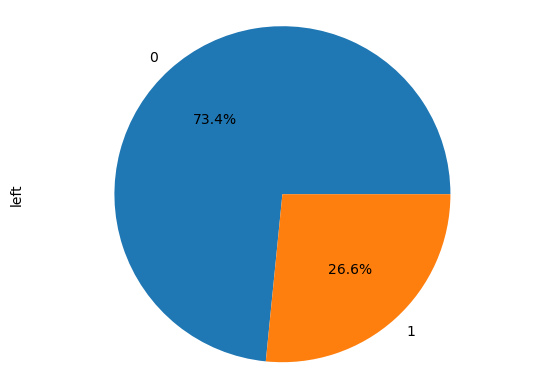

In [17]:
#target feature distribution
labels = merged_data['left'].dropna().unique()
merged_data.left.value_counts().plot(kind='pie', labels=labels, autopct='%1.1f%%')
plt.axis('equal')

We can see an evident **class imbalance in a target feature**. It shouldn't affect final requred metrix ROC-AUC as it's not sensitive to class imbalance, nevertheless it should be taken into account in the modeling, namely at data train-test split.

Let's see coming/leaving customers clients related to time.

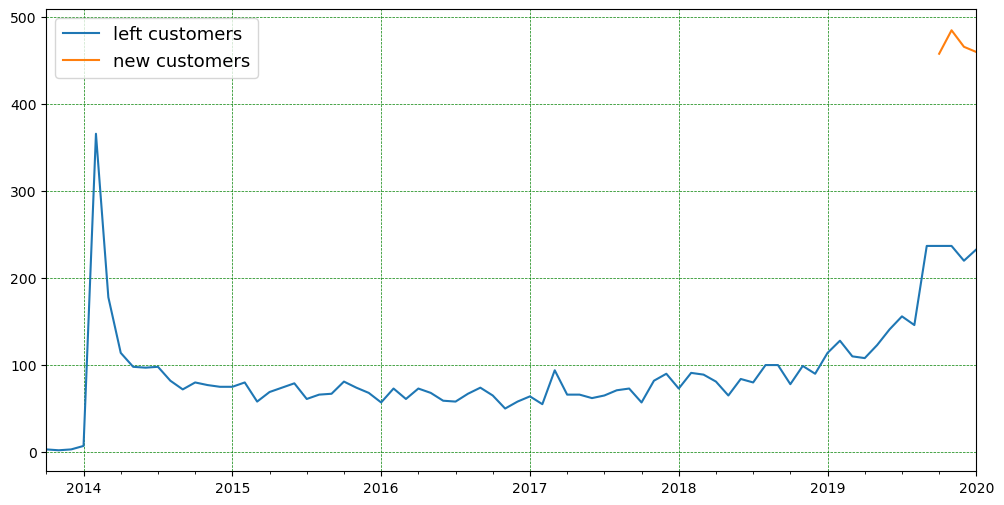

In [18]:
ax = merged_data.groupby('begin_date')['begin_date'].count().plot()
ax = merged_data[merged_data['left']=='1'].groupby('end_date')['end_date'].count().plot(figsize=(12,6))

plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
ax.legend(['new customers','left customers'], fontsize=13)

plt.xlabel('');

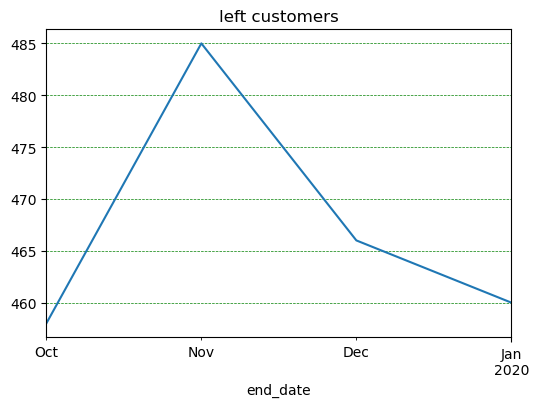

In [19]:
merged_data[merged_data['left']=='1'].groupby('end_date')['end_date'].count().plot(figsize=(6,4))

plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.title('left customers');

Availabe data is dated from 2014. 

*New customers* 
We can see a largest pick at the beginning of 2014 when many customers (370) started to use the client's services at once. Then the amount of new users drops drastically to the mid of 2014, and their amount flactuates from about 70 to 100 up to 2019.
In 2019 more customers start to appear again.

*Left customers*
Customers outflow starts in October 2019 with a pick in November 2019. Moreover the amount of leaving customers is almost double of the new ones. Strangely, the data churn is present only for this period. Perhaps we received not a full dataset from the client, it's an important point to confirm. 

In [20]:
#as mentioned before end_date and begin_date columns should be eliminated
merged_data = merged_data.drop(['end_date','begin_date'], axis=1)

Let's look at the numerical features.

Numerical features in relation to left customers


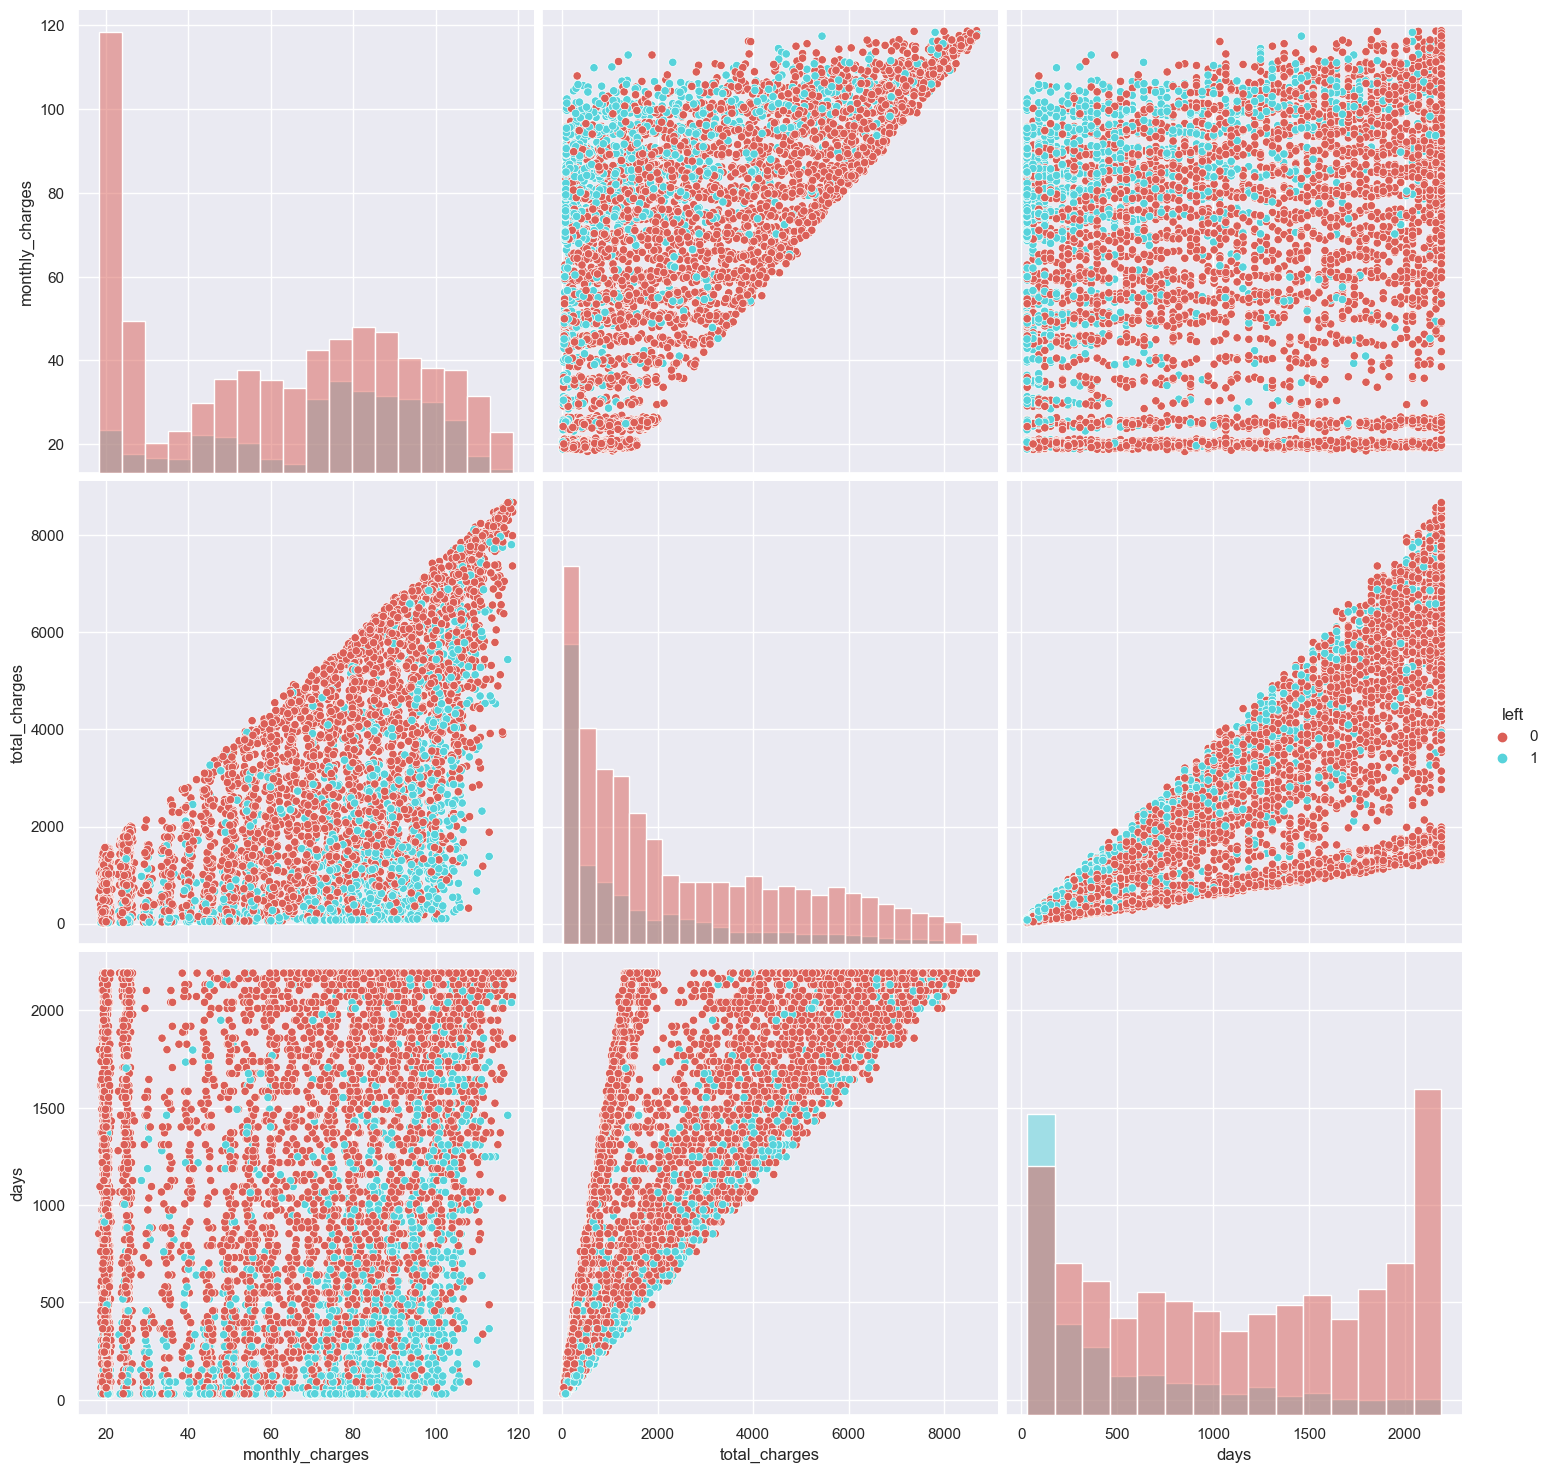

In [21]:
sns.set(rc={'figure.figsize': (20, 18)})

print('Numerical features in relation to left customers')
sns.pairplot(merged_data[['monthly_charges', 'total_charges', 'days', 'left']],
             hue='left', diag_kind="hist", height=5, palette='hls')    
plt.show()
print()

Main insights:

*monthly_charges* - scatter plot diagram shows that there's some correlation between the amount of monthly charges and the churn effect. People tend to leave in the first months, moreover the company loses those who pay more. Leaving customers usually pay more than 70 per month, although they can be noticed among those who pay from 30 to 70 especially at the beginning of the contract. Histogram confirms this fact, those who pay less usually stay. The ratio of leaving customers is much higher in a more expensive segment. 

*total_charges* - a similar pattern can be seen here, as there's a noticeable correlation between monthly_charges and total_charges. Leaving customers are mostly concentrated on the top part of the scatter plot. We can say that higher amount of charges is a very significant factor for customers.

*days* - There's also some correlation. It can be seen that intention to leave is much higher during first months. The longer a customer stays the more probable he won't leave. There's an evident threshold after which people prefer to stay. Let's find it.

[[<matplotlib.axis.XTick at 0x1fd54a9a610>,

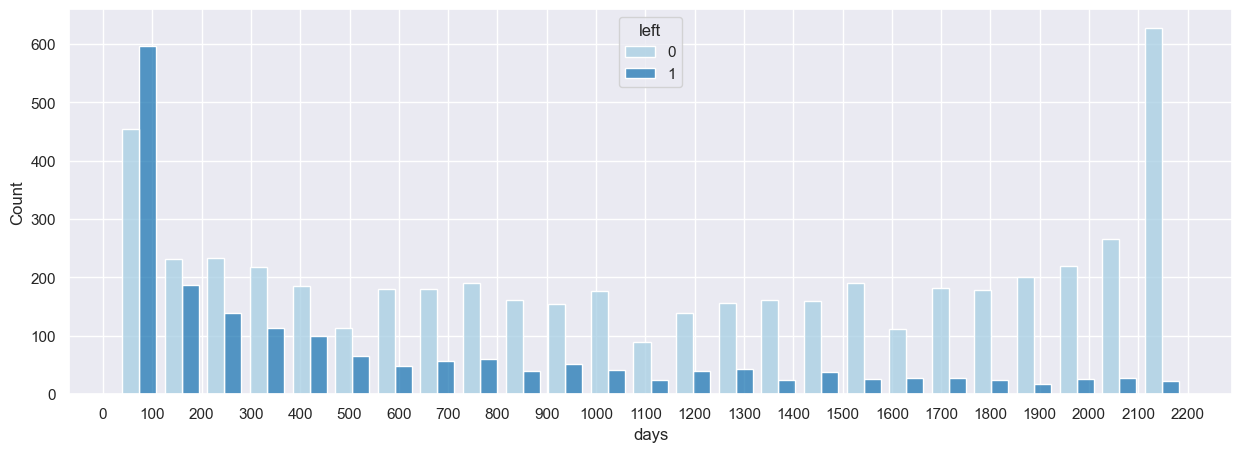

In [22]:
plt.figure(figsize=(15,5))
left_customers=sns.histplot(data=merged_data, x='days', multiple="dodge", shrink=.8, palette='Paired', hue='left',bins=25)
left_customers.set(xticks=np.arange(0,2300,100))

We can see that people leave during first 3-4 months. It can be a good insight for the marketing department to think about some retention strategy for first months

Now let's look at the categorical features.

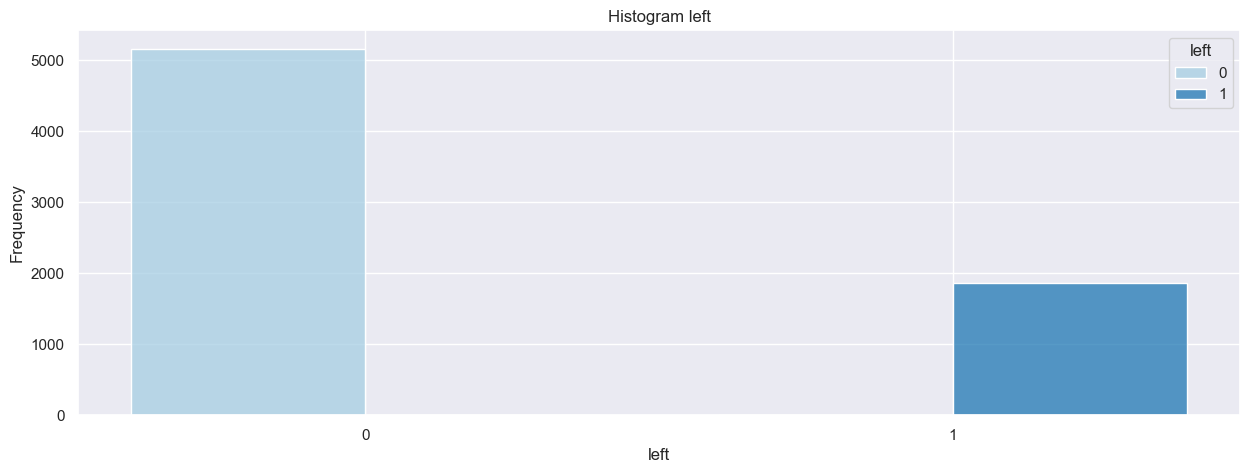

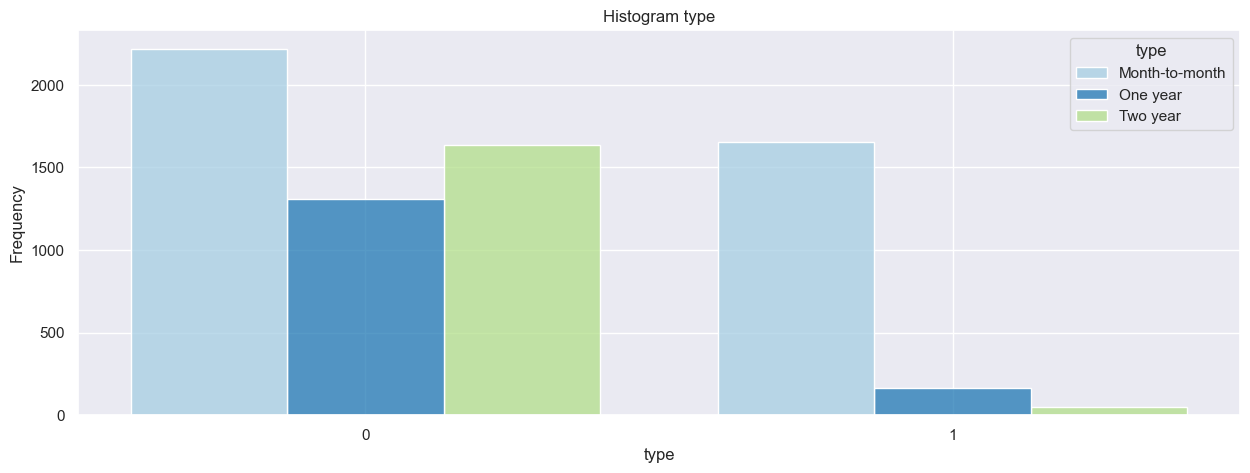

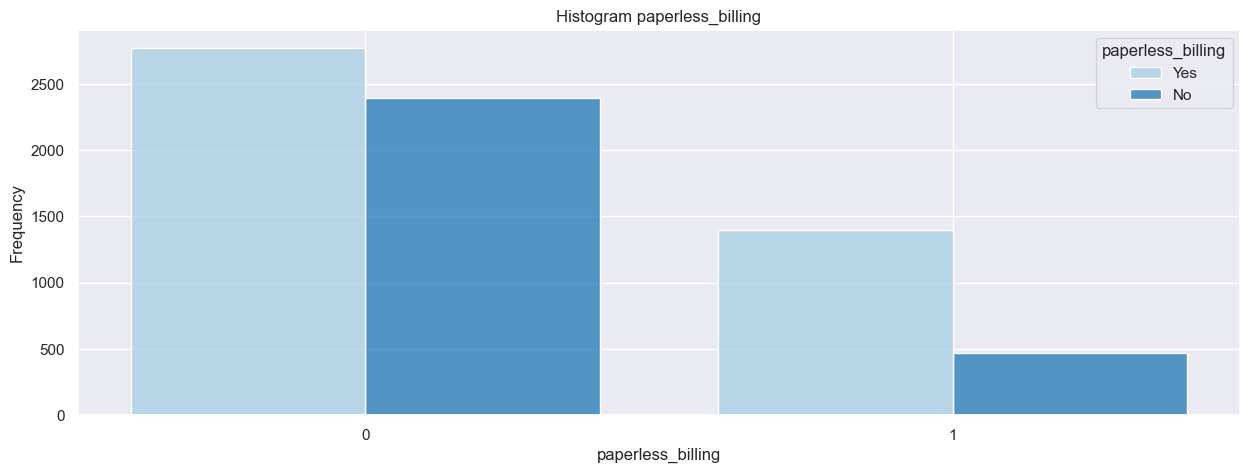

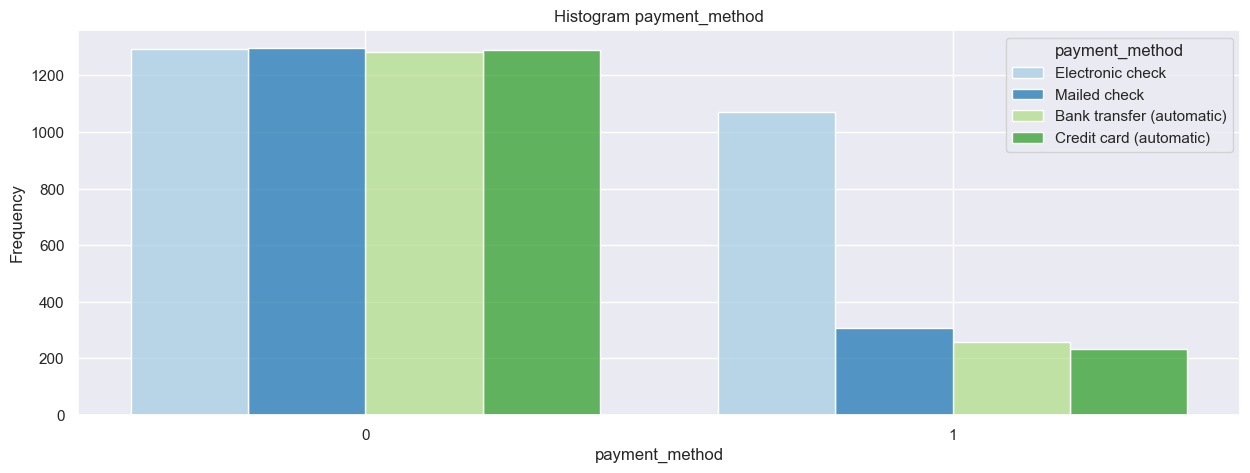

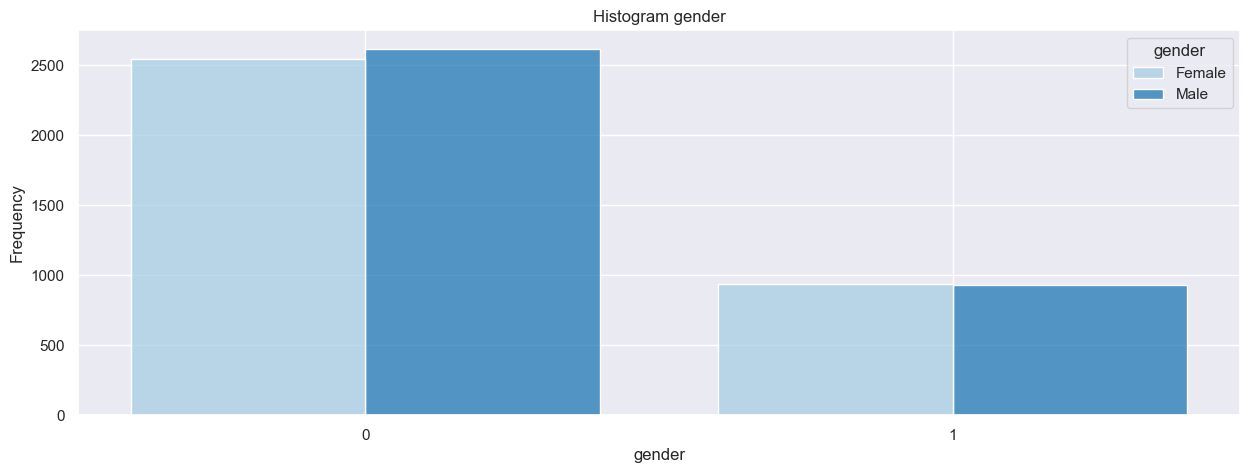

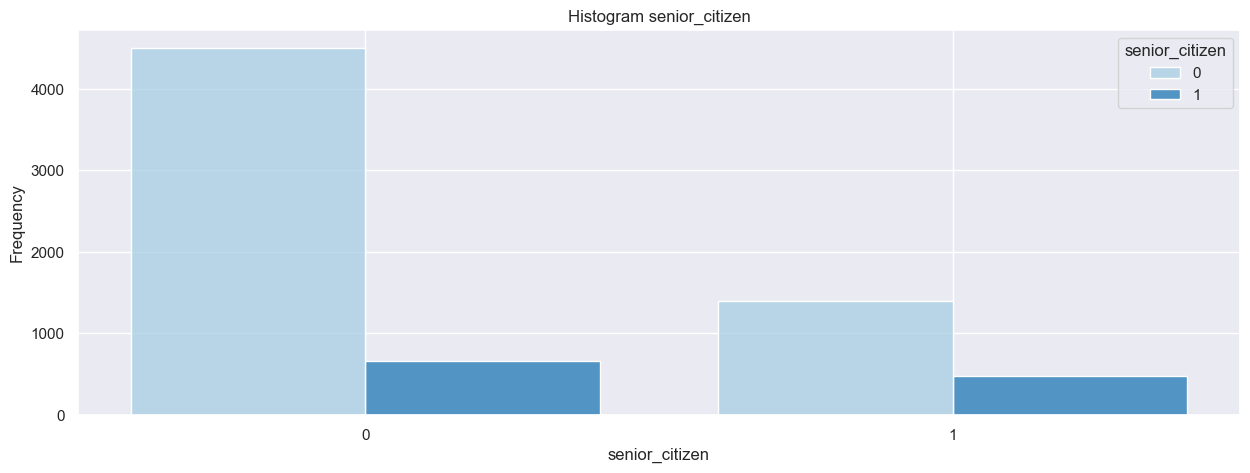

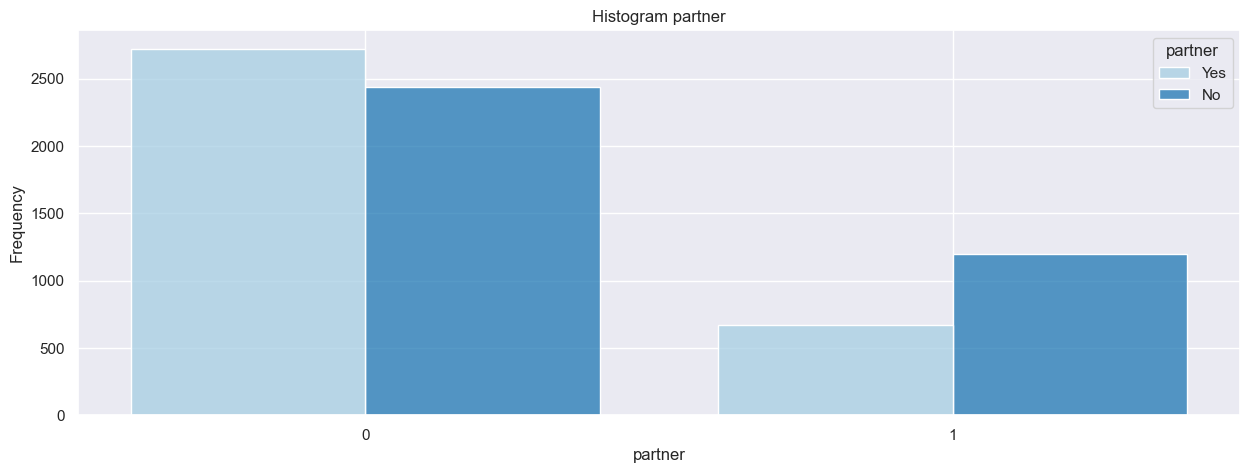

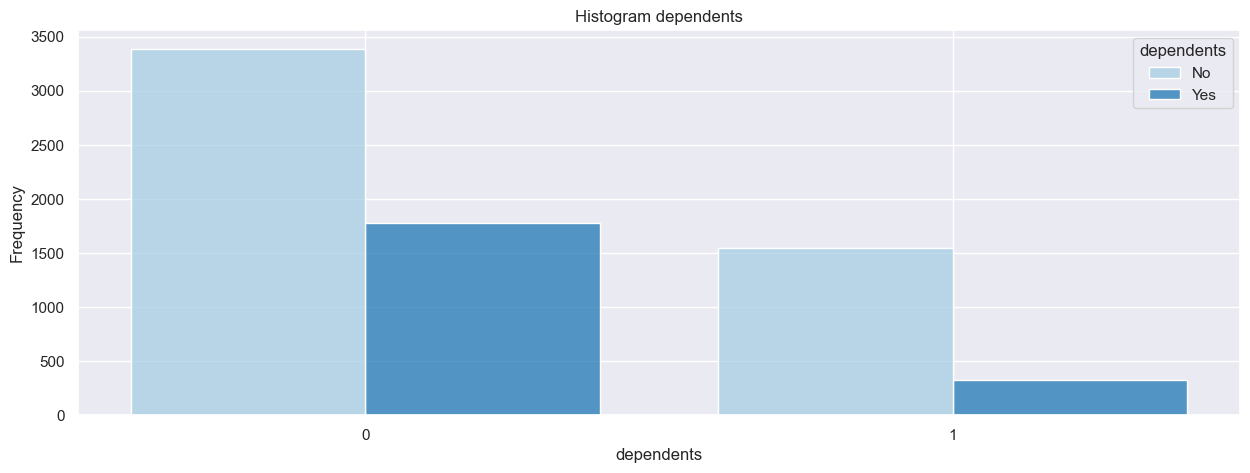

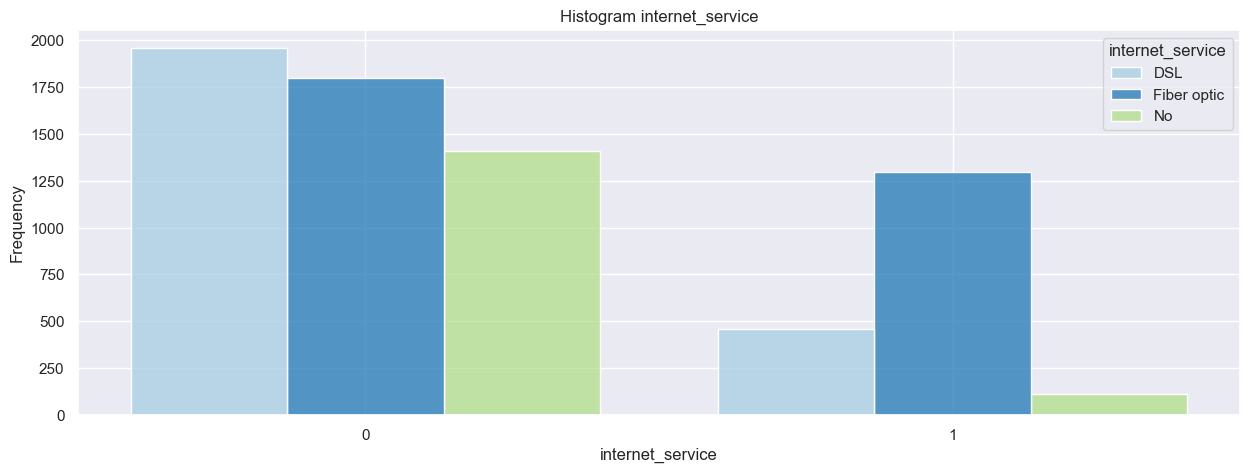

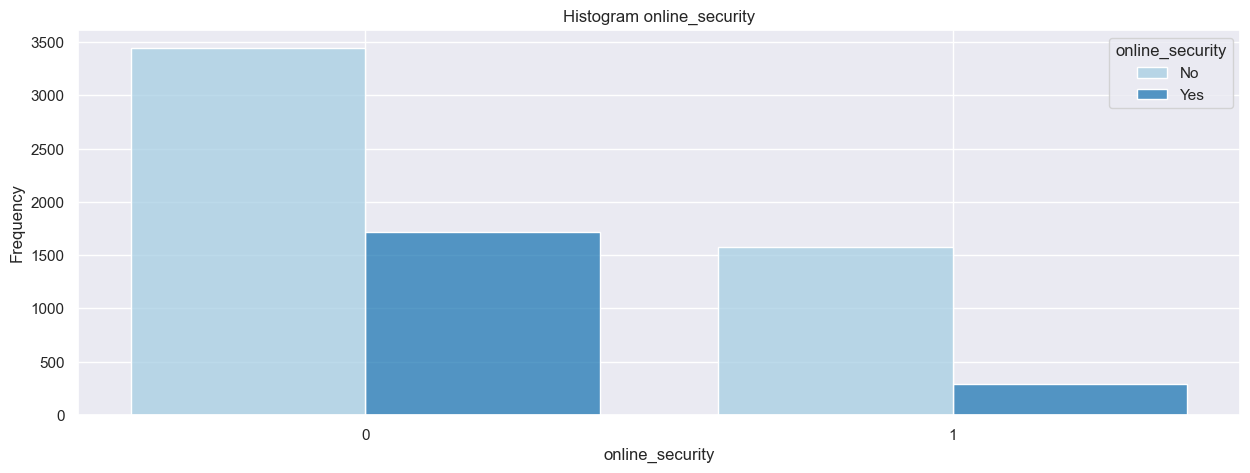

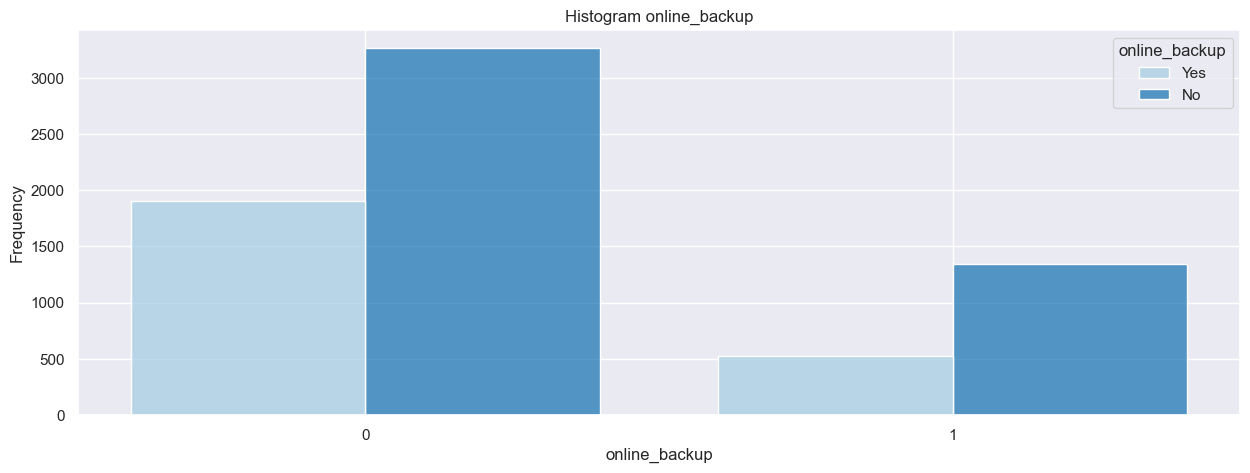

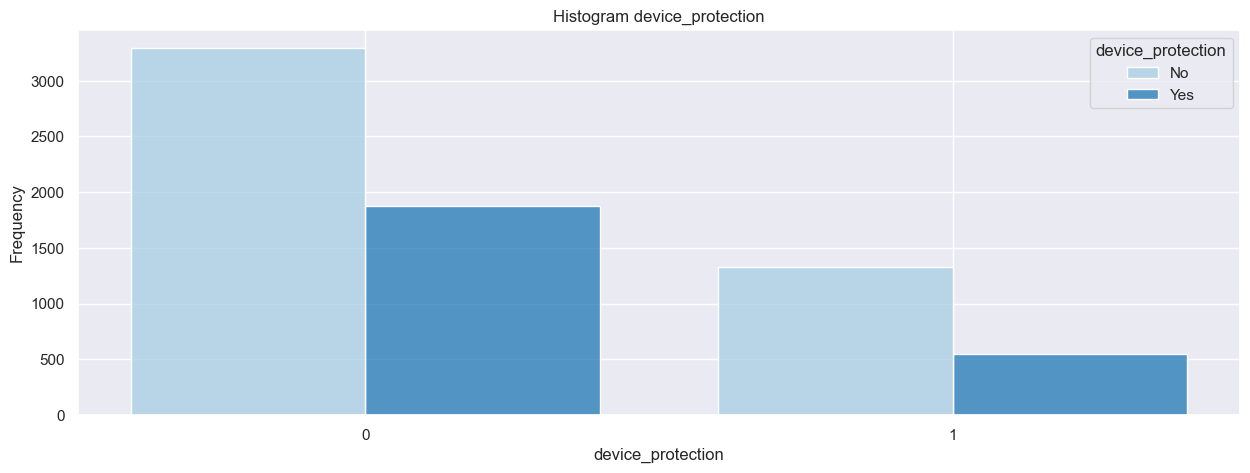

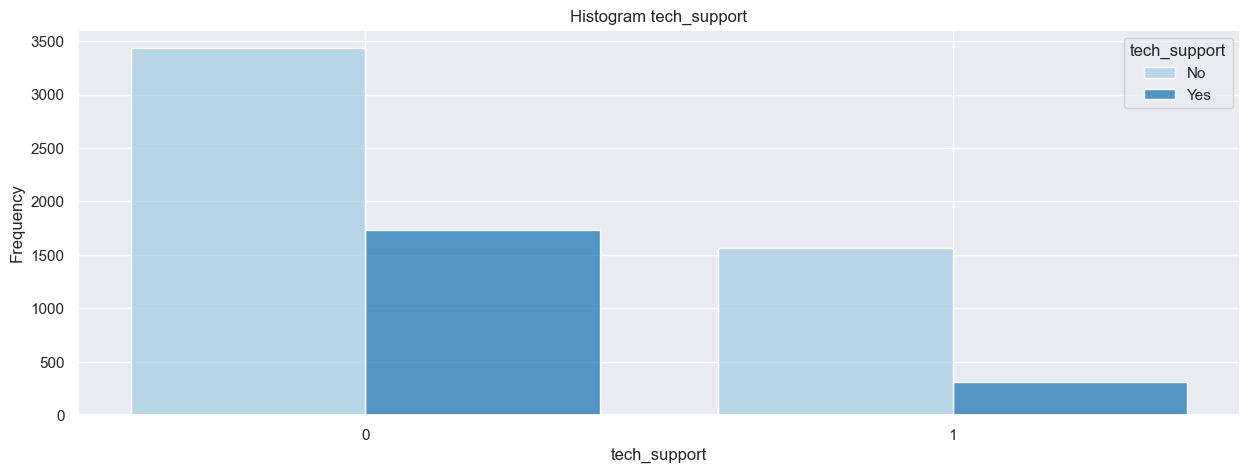

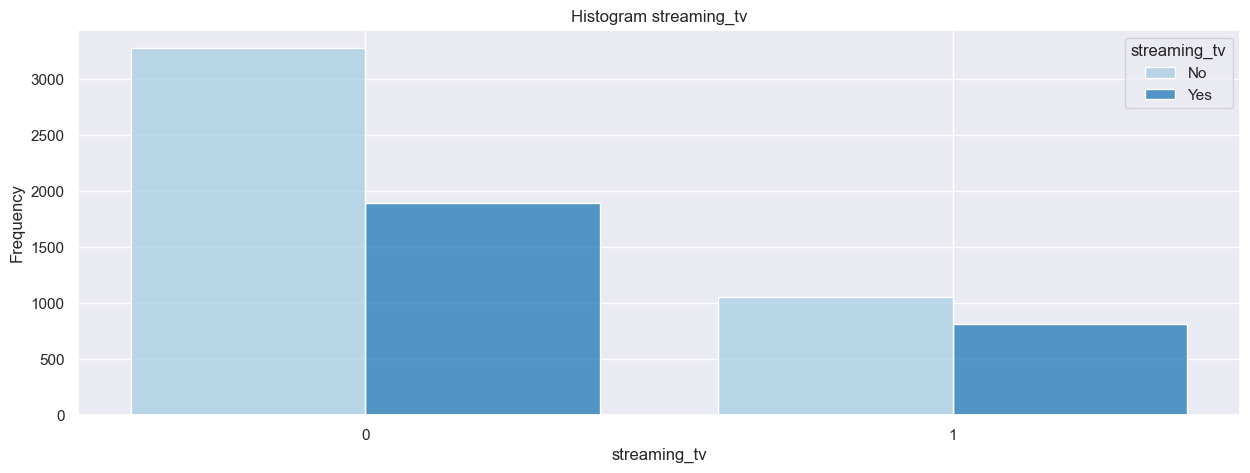

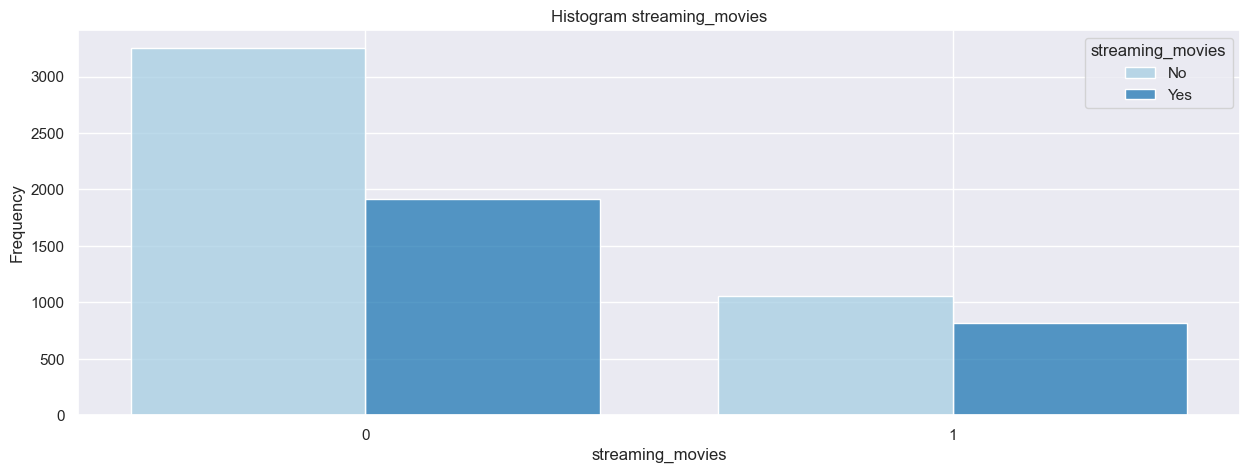

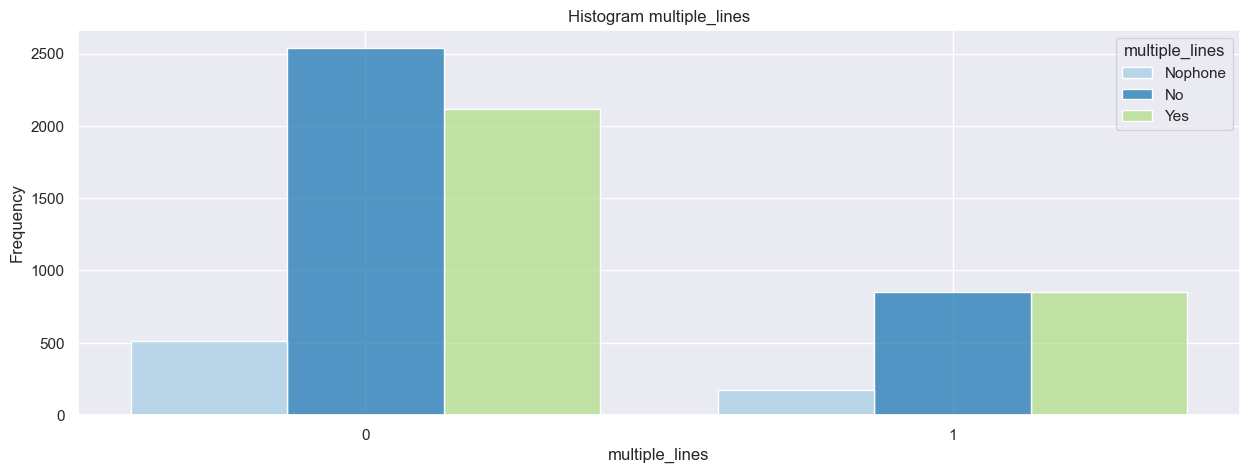

In [23]:
categorical_features = merged_data.select_dtypes(include=['object','int64']).columns
categorical_features = categorical_features.drop('days')

for i in categorical_features:
    plt.figure(figsize=(15,5))
    sns.histplot(data=merged_data, x='left', multiple="dodge", shrink=.8, palette='Paired', hue=i)
    plt.ylabel('Frequency')
    plt.xlabel(i)
    plt.title(f'Histogram {i}')
    plt.show()

**Categorical features main insights**

*type* - Even though the amount of customers with month-to-month payment type contract is higher than with one/two year contract, relatively speaking churn rate is higher among such client;

*paperless_billing* - churn rate among people receiving paperless bills is higher;

*payment_method* - among leaving customers stand out those who use electronic check, whereas there's no significant difference on payment method among loyal customers; 

*gender* - there's no gender correlation;

*senior_citizen* - leaving rate in senior users is higher, but it's not so representable as there's less information about such users, they are fewer.

*partner* - those having a partner have higher tendency to leave;

*dependents* - there're more dependants among those who tend to stay; 

*internet_service* - among those using internet, we can see that leaving customers mostly use Fiber optic connection type 

About the rest of the features in general it can be noted that leaving customers don't use additional services except for streaming TV and movies. 

Therefore *A leaving customer persona* description would be like that: most probably it'is a single person of any gender without kids (other dependants). He tends to save - financial aspect is very important for him. He doesn't like to have long-term commitment, that's why prefers to choose monthly payment. He prefers electronic bills and uses fiber optic internet connection. Leaving customers don't use additional services except for streaming TV and movies. In general his intention to leave happens in  first 3-4 months.

A deeper correlation understanding can be reached throuh multicorrelation analysis.

**Relationship between the features - correlation**
Since we have both numerical and catergorical variables, let's  calculate 𝜙k correlation coefficient.

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'senior_citizen', 'days']


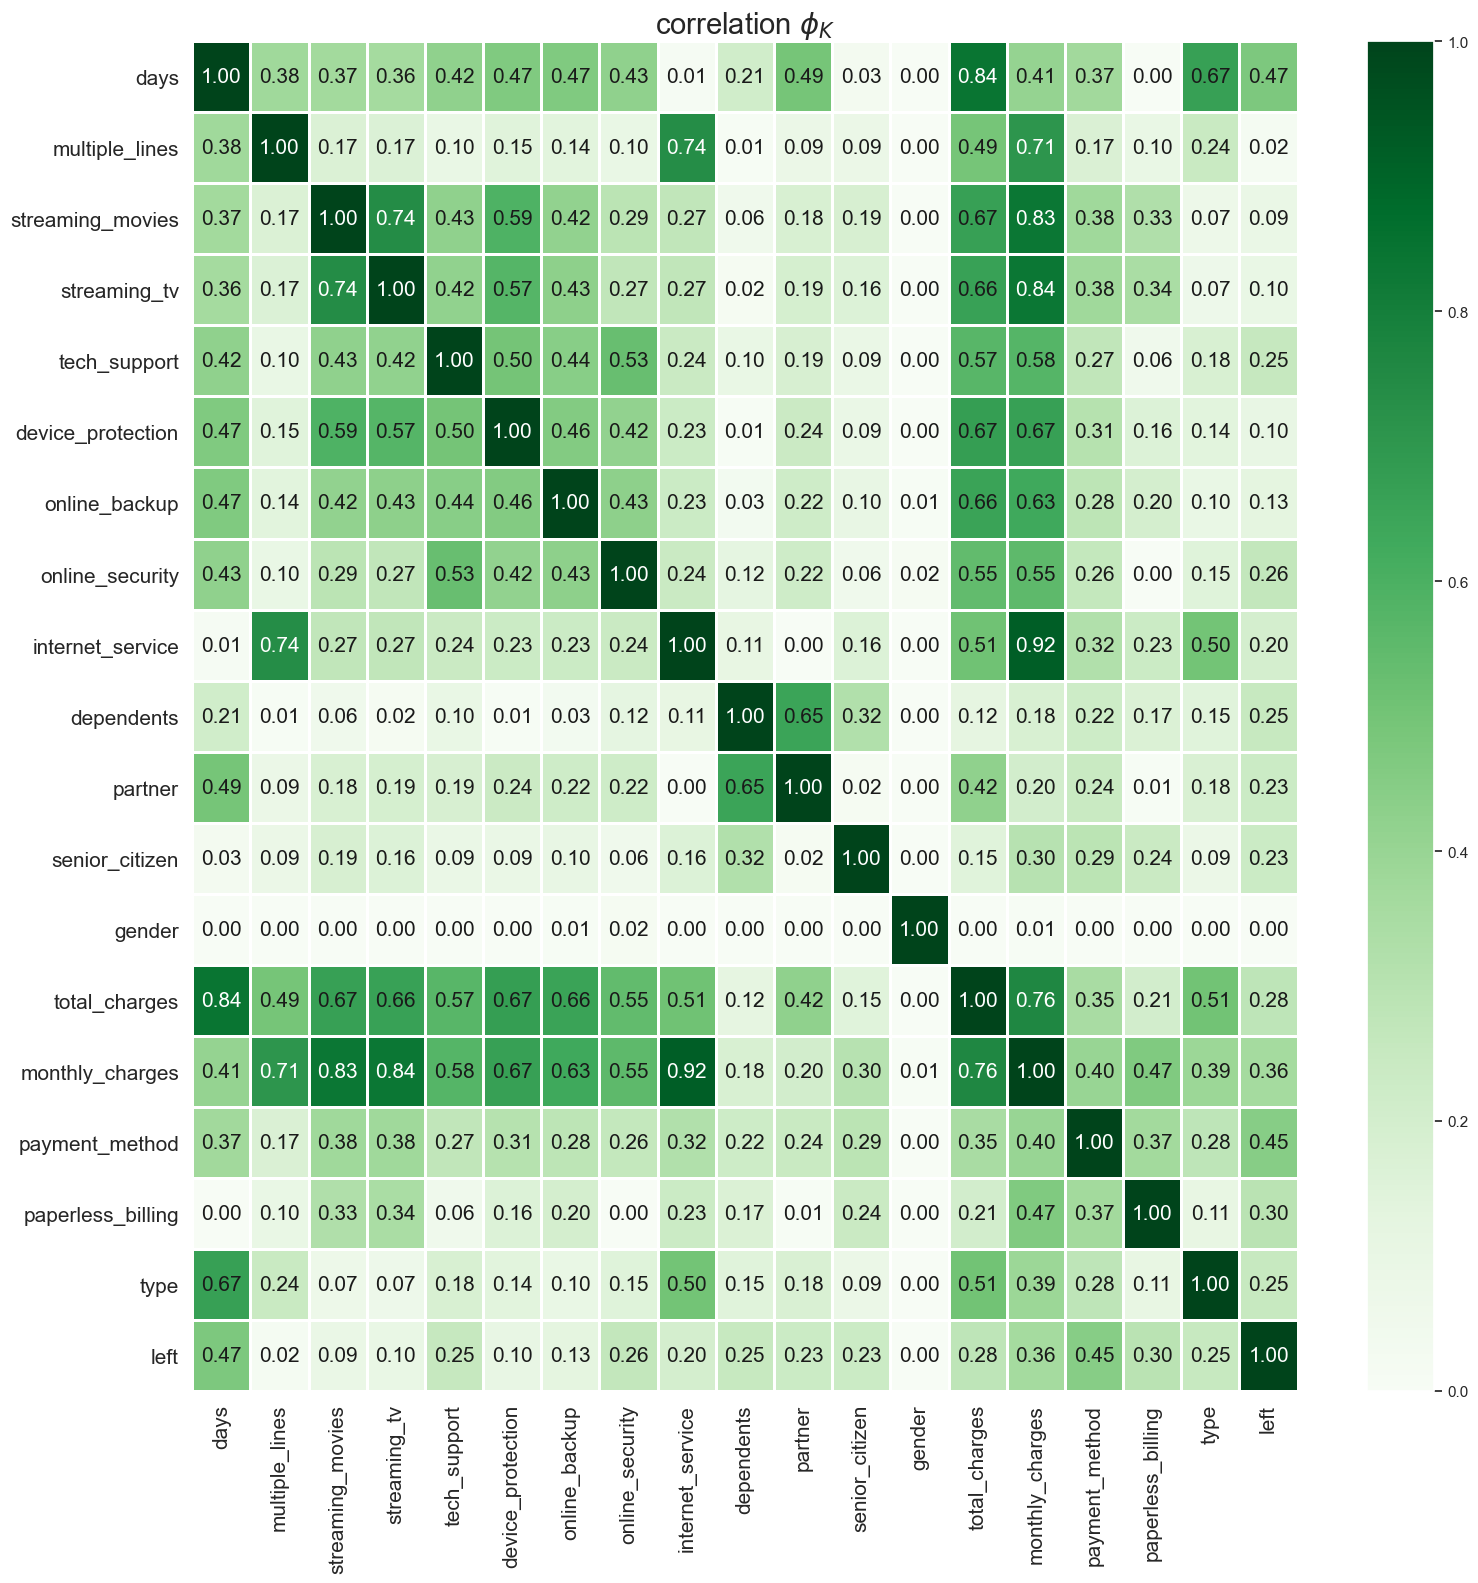

In [24]:
phik_overview = merged_data.phik_matrix()
phik_overview.round(2)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(16, 16))
plt.tight_layout()

Additionally let's look at statistical significance of the calculated correleation coefficients, as both show no correlation with the target feature. 

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'senior_citizen', 'days']


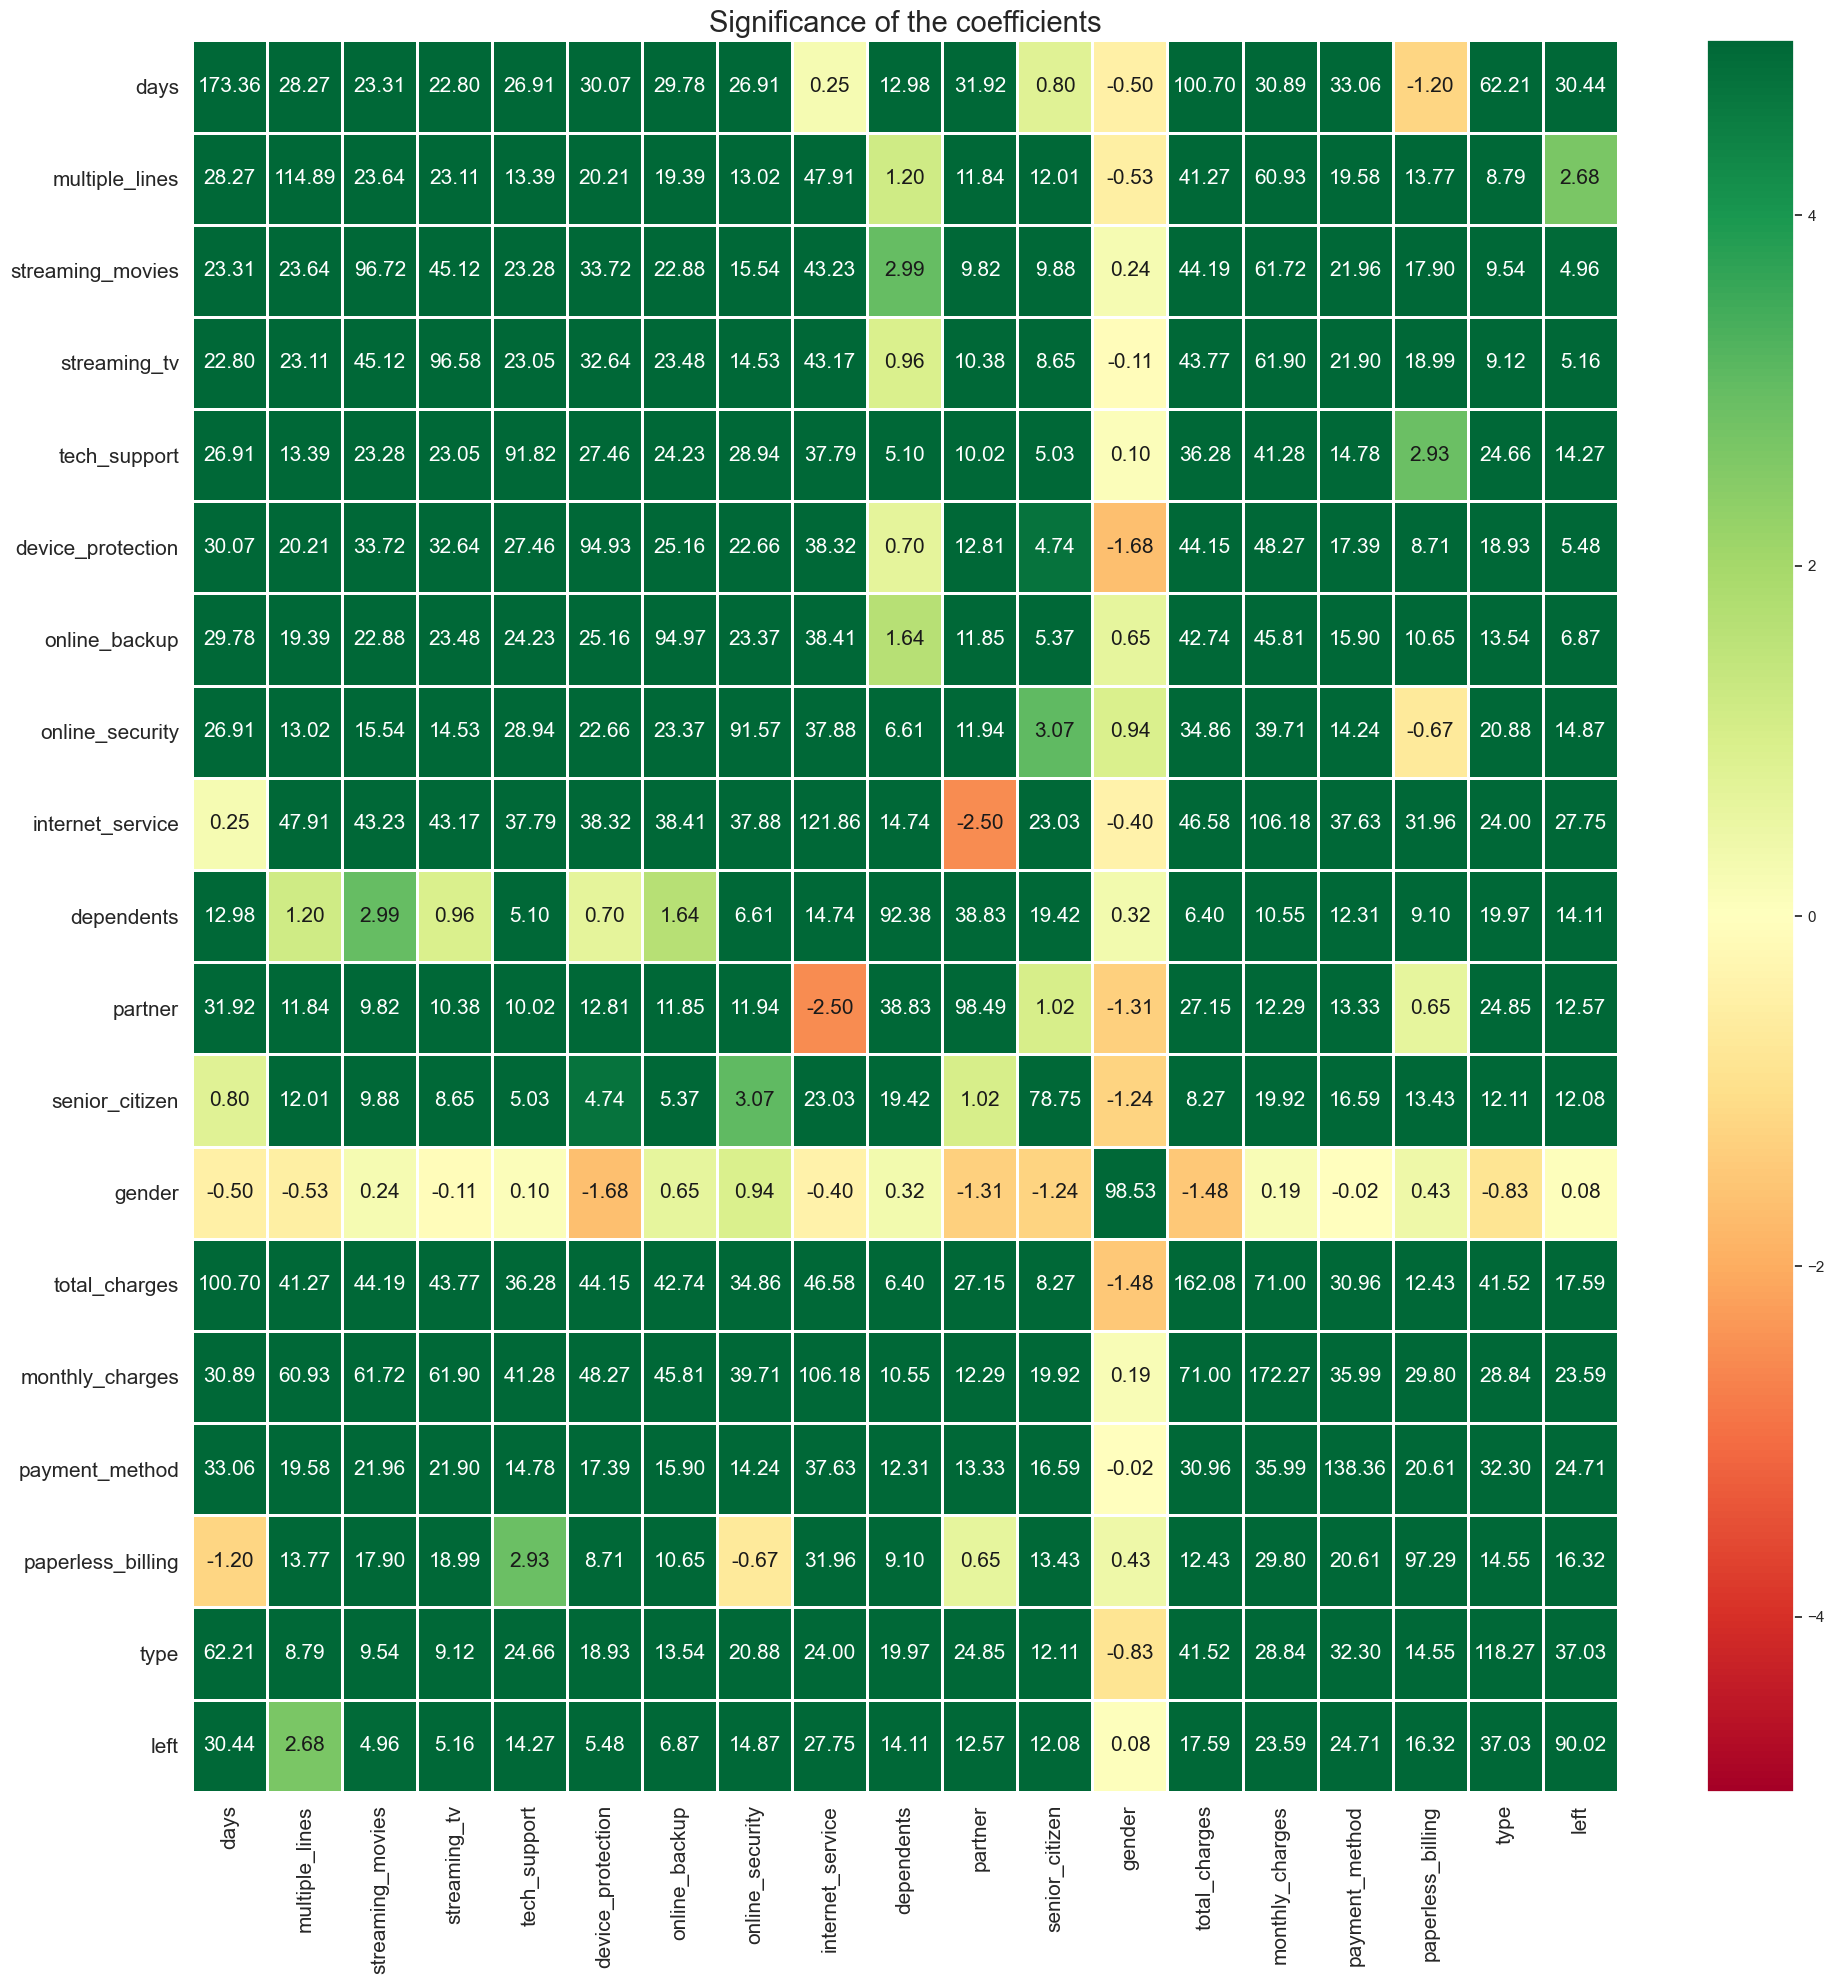

In [25]:
significance_overview = merged_data.significance_matrix()
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1.5, figsize=(20, 20))
plt.tight_layout()

From both tables we can definitelly remove 'gender' and 'multiple_line' features.
Moreover we can see a similar behaviour of 'monthly_charges' and 'total_charges' features, taken into account that the second has higher correlation with the new sinthetic feature 'days' and the fact that leaving clients have monthly payments, tending to leave on the 3-4 month, it's better to remove 'total_charges' feature.
Later when we need to choose the appropriate model we can come back to this section.

In [26]:
#Leaving only relevant features

final_data = merged_data.drop(['gender', 'multiple_lines','total_charges'], axis=1)

print(final_data.info())
final_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   left               7032 non-null   object 
 1   type               7032 non-null   object 
 2   paperless_billing  7032 non-null   object 
 3   payment_method     7032 non-null   object 
 4   monthly_charges    7032 non-null   float64
 5   senior_citizen     7032 non-null   int64  
 6   partner            7032 non-null   object 
 7   dependents         7032 non-null   object 
 8   internet_service   7032 non-null   object 
 9   online_security    7032 non-null   object 
 10  online_backup      7032 non-null   object 
 11  device_protection  7032 non-null   object 
 12  tech_support       7032 non-null   object 
 13  streaming_tv       7032 non-null   object 
 14  streaming_movies   7032 non-null   object 
 15  days               7032 non-null   int64  
dtypes: float64(1), int64(2),

,left,type,paperless_billing,payment_method,monthly_charges,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,days
0,0,Month-to-month,Yes,Electronic check,29.85,0,Yes,No,DSL,No,Yes,No,No,No,No,31
1,0,One year,No,Mailed check,56.95,0,No,No,DSL,Yes,No,Yes,No,No,No,1036
2,1,Month-to-month,Yes,Mailed check,53.85,0,No,No,DSL,Yes,Yes,No,No,No,No,61
3,0,One year,No,Bank transfer (automatic),42.30,0,No,No,DSL,Yes,No,Yes,Yes,No,No,1371
4,1,Month-to-month,Yes,Electronic check,70.70,0,No,No,Fiber optic,No,No,No,No,No,No,61


**EDA conclusions**

- after dataframes merging a new synthetic feature was added **days** - number of days from the beginning of the contract, whereas 'begin_date' and 'end_date' were eliminated to prevent target leakage;
- **class imbalance in a target feature** was detected, which was later considered in data train-test split; 
- strangely, the **data churn is present only for the end of 2019**. Perhaps we received not a full dataset from the client, it's an important point to confirm;
- **a detailed persona of a leaving customer was described**: most probably it'is a single person of any gender without kids (other dependants). He tends to save - financial aspect is very important for him. He doesn't like to have long-term commitment, that's why prefers to choose monthly payment. He prefers electronic bills and uses fiber optic internet connection. Leaving customers don't use additional services except for streaming TV and movies. In general his intention to leave happens in  first 3-4 months.
- **to detect multicollinearity the 𝜙k correlation coefficient** was calculated, it works for both numerical and catergorical variables. Based on the coefficient the following features were removed - 'gender', 'multiple_line' and 'total_charges'.


 

## Modeling

### Data split

In [27]:
# Data split to train and test samples (3:1), not forgetting about data stratification

target = final_data['left']
features = final_data.drop('left', axis=1)

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=121222, stratify=target)

### Model selection and hyperparameters tuning

The following models will be considered: LogisticRegression(), RandomForestClassifier(), XGBClassifier() and CatBoostClassifier().
Hyperparameters tuning will be done applying GridSearchCV or RandomizedSearchCV (to improve search speed).
The following will be taken into consideration:
- linear models require standardised numeric data, so we'll add StandardScaler() to numeric features in LogisticRegression()
- categorical data can stay 'dirty' for CatBoostClassifier(), whereas it should be encoded with OneHotEncoder() in linear models and with OrdinalEncoder() in 'forest' models

### LogisticRegression

In [28]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

numeric_features = features_train.loc[:, ['monthly_charges','days']].columns
numeric_transformer = StandardScaler()

categorical_features = features_train.select_dtypes(include='object').columns
categorical_transformer_OHE = OneHotEncoder(handle_unknown="ignore",
                                        drop='first')

preprocessor_lr = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features),
                                                  ("cat", categorical_transformer_OHE, categorical_features)],
                                    remainder="passthrough")

model_lr = Pipeline(steps=[('preprocessor', preprocessor_lr),
                           ('lr', LogisticRegression(random_state=121222))])


lr_params={'lr__C':[0.01, 0.1, 1, 10, 100],
           'lr__solver' : ['newton-cg', 'lbfgs', 'liblinear']}

grid_search_lr = GridSearchCV(estimator=model_lr,
                              param_grid=lr_params,
                              scoring='roc_auc',
                              cv=5,
                              error_score='raise')
#for param in grid_search_lr.get_params().keys():
#    print(param)

grid_search_lr.fit(features_train, target_train)

print('best params:',  grid_search_lr.best_params_)
print('best score:',  grid_search_lr.best_score_)


best params: {'lr__C': 1, 'lr__solver': 'lbfgs'}
best score: 0.8415904782669147


### RandomForestClassifier

In [29]:
categorical_transformer_OE = OrdinalEncoder(handle_unknown="use_encoded_value", 
                                            unknown_value = -1)

preprocessor = ColumnTransformer(transformers=[#("num", numeric_transformer, numeric_features),
                                               ("cat", categorical_transformer_OE, categorical_features)],
                                 remainder="passthrough")

model_rfc = Pipeline(steps=[('preprocessor', preprocessor),
                            ('rfc', RandomForestClassifier(class_weight='balanced',
                                                           bootstrap=True,
                                                           random_state=121222))])

rfc_params = {'rfc__max_depth': (4, 50),
               'rfc__max_features': ['sqrt'],
               'rfc__min_samples_leaf': (1, 60),
               'rfc__n_estimators': (50, 250), 
               'rfc__criterion': ['entropy']}
                                   
grid_search_rfc = RandomizedSearchCV(model_rfc, 
                                     rfc_params,
                                     scoring = 'roc_auc', 
                                     cv = 5, 
                                     n_jobs = -1,  
                                     verbose = 3,
                                     error_score='raise')


grid_search_rfc.fit(features_train, target_train)

print('best params:',  grid_search_rfc.best_params_)
print('best score:',  grid_search_rfc.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\dashu\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


best params: {'rfc__n_estimators': 250, 'rfc__min_samples_leaf': 60, 'rfc__max_features': 'sqrt', 'rfc__max_depth': 50, 'rfc__criterion': 'entropy'}
best score: 0.848635038008782


### XGBClassifier

In [30]:
model_xbc = Pipeline(steps=[('preprocessor', preprocessor),
                            ('xbc', XGBClassifier(random_state=121222,
                                                  eval_metric='mlogloss',
                                                  ))])

xbc_params = {'xbc__max_depth': (2, 20),
               'xbc__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4],
               'xbc__gamma': (1, 9),
               'xbc__reg_alpha' : (40, 180),
               'xbc__reg_lambda' : (0.0, 1.0),
               'xbc__subsample': (0.5, 1.0),
               'xbc__colsample_bytree' : (0.5, 1),
               'xbc__min_child_weight' : (1, 10),
               'xbc__n_estimators': [50, 100, 200, 300, 400, 500, 600]}

 
grid_search_xbc = RandomizedSearchCV(model_xbc,                               
                                    xbc_params,
                                    scoring='roc_auc',
                                    cv=5,
                                    n_jobs=-1, 
                                    error_score='raise', 
                                    verbose=0)

grid_search_xbc.fit(features_train, target_train)

print('best params:',  grid_search_xbc.best_params_)
print('best score:',  grid_search_xbc.best_score_)


C:\Users\dashu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


best params: {'xbc__subsample': 1.0, 'xbc__reg_lambda': 0.0, 'xbc__reg_alpha': 40, 'xbc__n_estimators': 500, 'xbc__min_child_weight': 1, 'xbc__max_depth': 20, 'xbc__learning_rate': 0.01, 'xbc__gamma': 1, 'xbc__colsample_bytree': 0.5}
best score: 0.8487039105247417


### CatBoostClassifier

In [31]:
cf=list(categorical_features)

model_cb = CatBoostClassifier(random_state=121222,
                              cat_features=cf,
                              logging_level='Silent')

cb_params = {'depth' : [2, 4],
             'learning_rate' : [0.5, 0.6],
             'iterations' : [400,500,600],
             'l2_leaf_reg': [1,2]}
             

grid_search_cb = GridSearchCV(model_cb, 
                              cb_params,
                              scoring='roc_auc', 
                              cv=5, 
                              n_jobs=-1,  
                              verbose=3,
                              error_score='raise')

grid_search_cb.fit(features_train, target_train)

print('best params:',  grid_search_cb.best_params_)
print('best score:',  grid_search_cb.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
best params: {'depth': 2, 'iterations': 500, 'l2_leaf_reg': 2, 'learning_rate': 0.6}
best score: 0.937770035781272


In [32]:
#Results representation in one table
rows = [['LogisticRegression()', round(grid_search_lr.best_score_,2)],
        ['RandomForestClassifier()', round(grid_search_rfc.best_score_,2)],
        ['XGBClassifier()', round(grid_search_xbc.best_score_,2)],
        ['CatBoostClassifier()', round(grid_search_cb.best_score_,2)]]
columns = ['Model', 'ROC-AUC']
 
model_results = pd.DataFrame(rows, columns=columns)
model_results

,Model,ROC-AUC
0,LogisticRegression(),0.84
1,RandomForestClassifier(),0.85
2,XGBClassifier(),0.85
3,CatBoostClassifier(),0.94


We can see that CatBoostClassifier() model took the lead by a huge margin, its ROC-AUC score is 0.94

### Best model testing and features importance analysis

In [33]:
final_model = CatBoostClassifier(random_state=121222,
                                 cat_features=cf,
                                 depth=2, 
                                 iterations=500, 
                                 l2_leaf_reg=2, 
                                 learning_rate=0.6,
                                 logging_level='Silent').fit(features_train, target_train)

In [34]:
features_importance = final_model.get_feature_importance()
pd.DataFrame(features_importance, index=features_train.dtypes.index, columns=['features_importance'])\
    .sort_values(by='features_importance', ascending = False).style.bar(color='#70b4b8')

,features_importance
days,79.217665
monthly_charges,10.462072
type,4.378131
internet_service,1.915020
payment_method,1.170940
online_security,0.555934
paperless_billing,0.531054
tech_support,0.466315
senior_citizen,0.321029
streaming_tv,0.269064


It's clear that the most important feature determining the fact that a client might leave is 'days' - number of days passed from the beginning of the subscription. The second important feature is monthly_charges. Another major factor is payment type - monthly or 1-2 year contract. 
Also the following features can stand out with some level of importance: internet_service, payment_method, online_security, paperless_billing and tech_support. All the rest of the features are not that important.

In [35]:
#Testing final model
predict_proba = grid_search_cb.predict_proba(features_test)[:, 1]
roc_auc_score(target_test, predict_proba)

0.9454052682298967

The result on the test sample is satisfying. Let's look at the ROC-curve

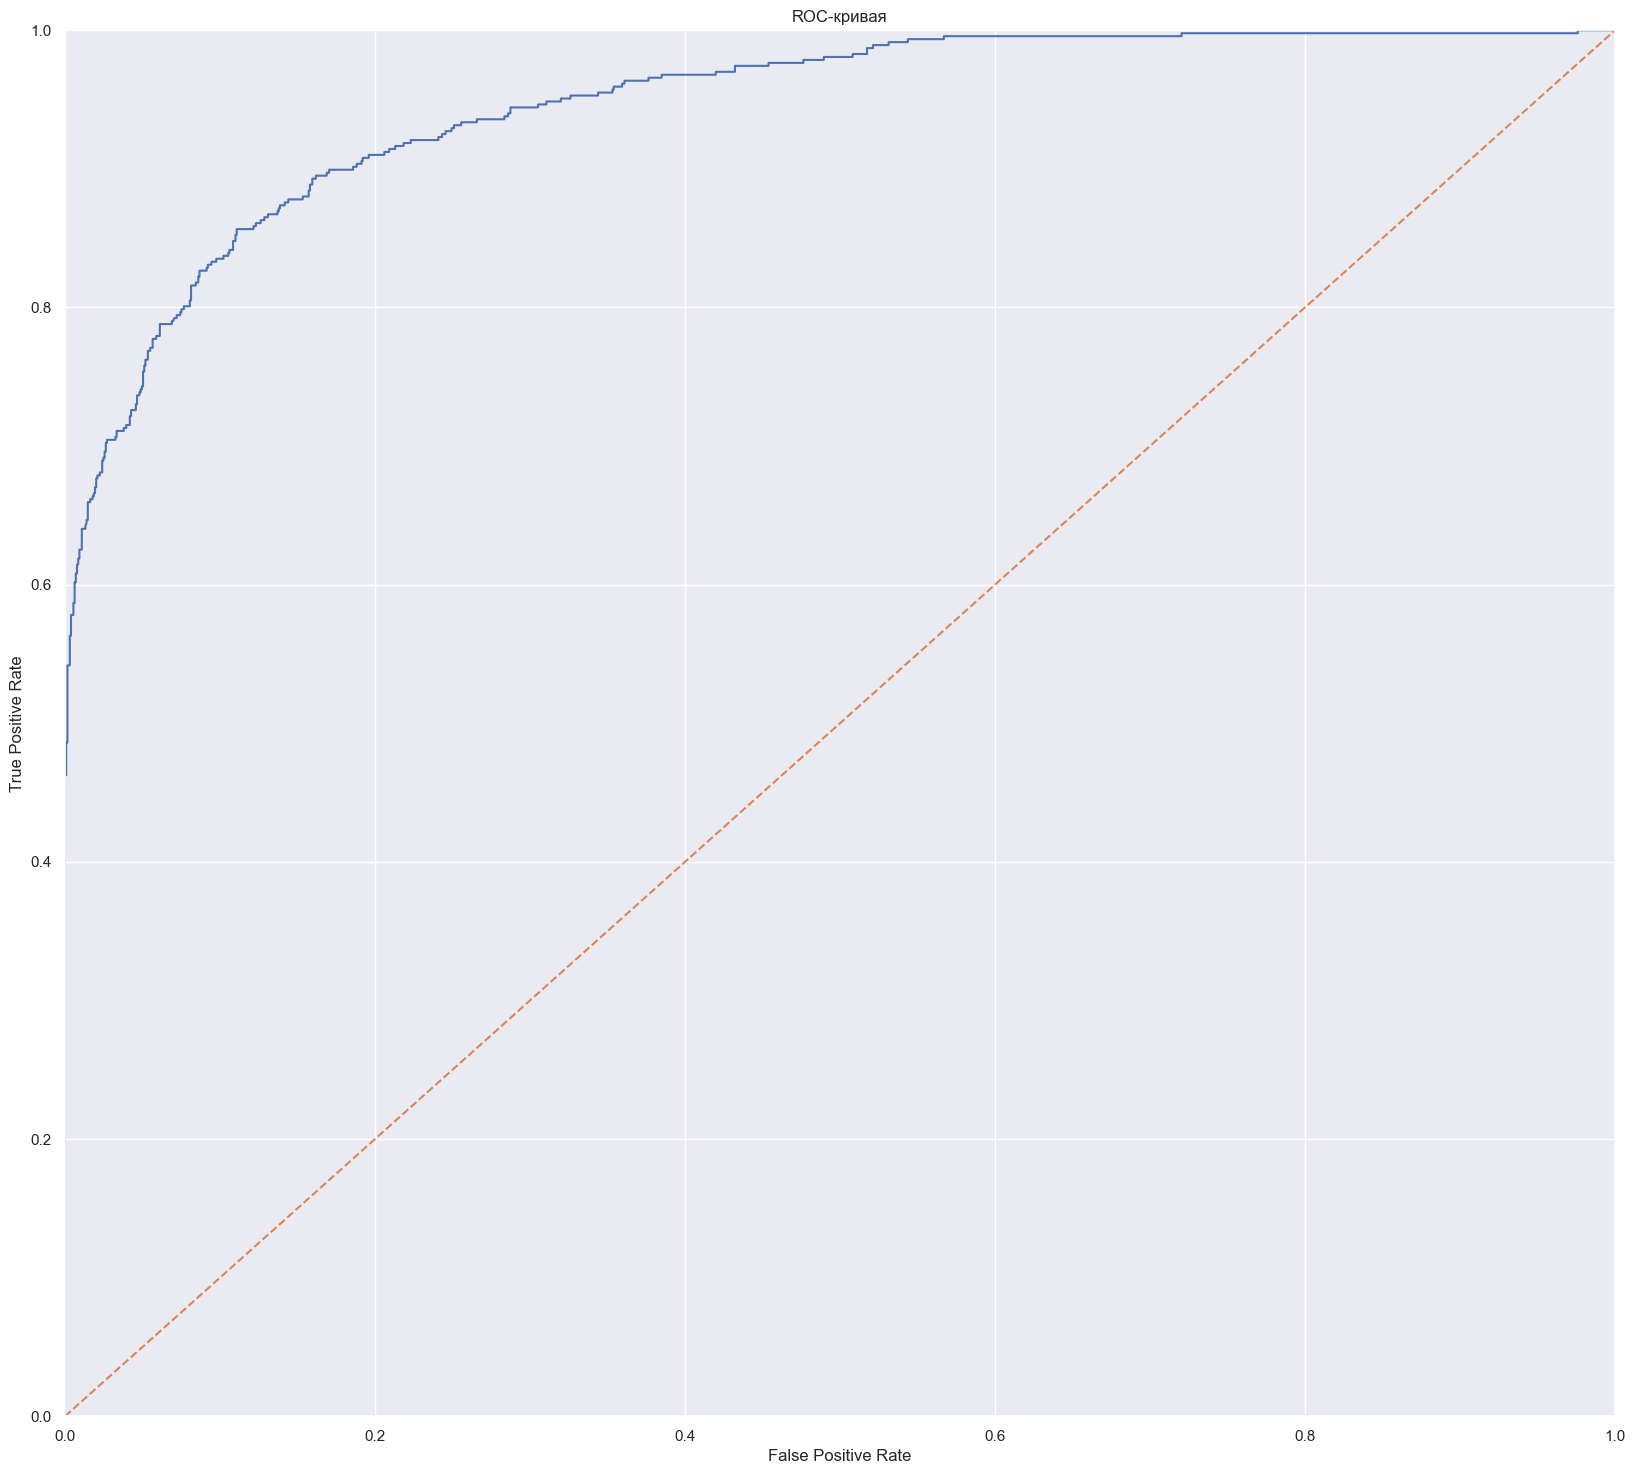

In [36]:
target_t = target_test.map({'1': 1, '0': 0}).astype(int)

probabilities_test = grid_search_cb.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_t, probabilities_one_test)# < напишите код здесь >

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

It can be seen that model performance is quite high, the curve is close to the top-left corner.
Let's look at the confusion matrix of the model.

Accuracy: 0.8947667804323094
Precision: 0.8472906403940886
Recall: 0.7366167023554604


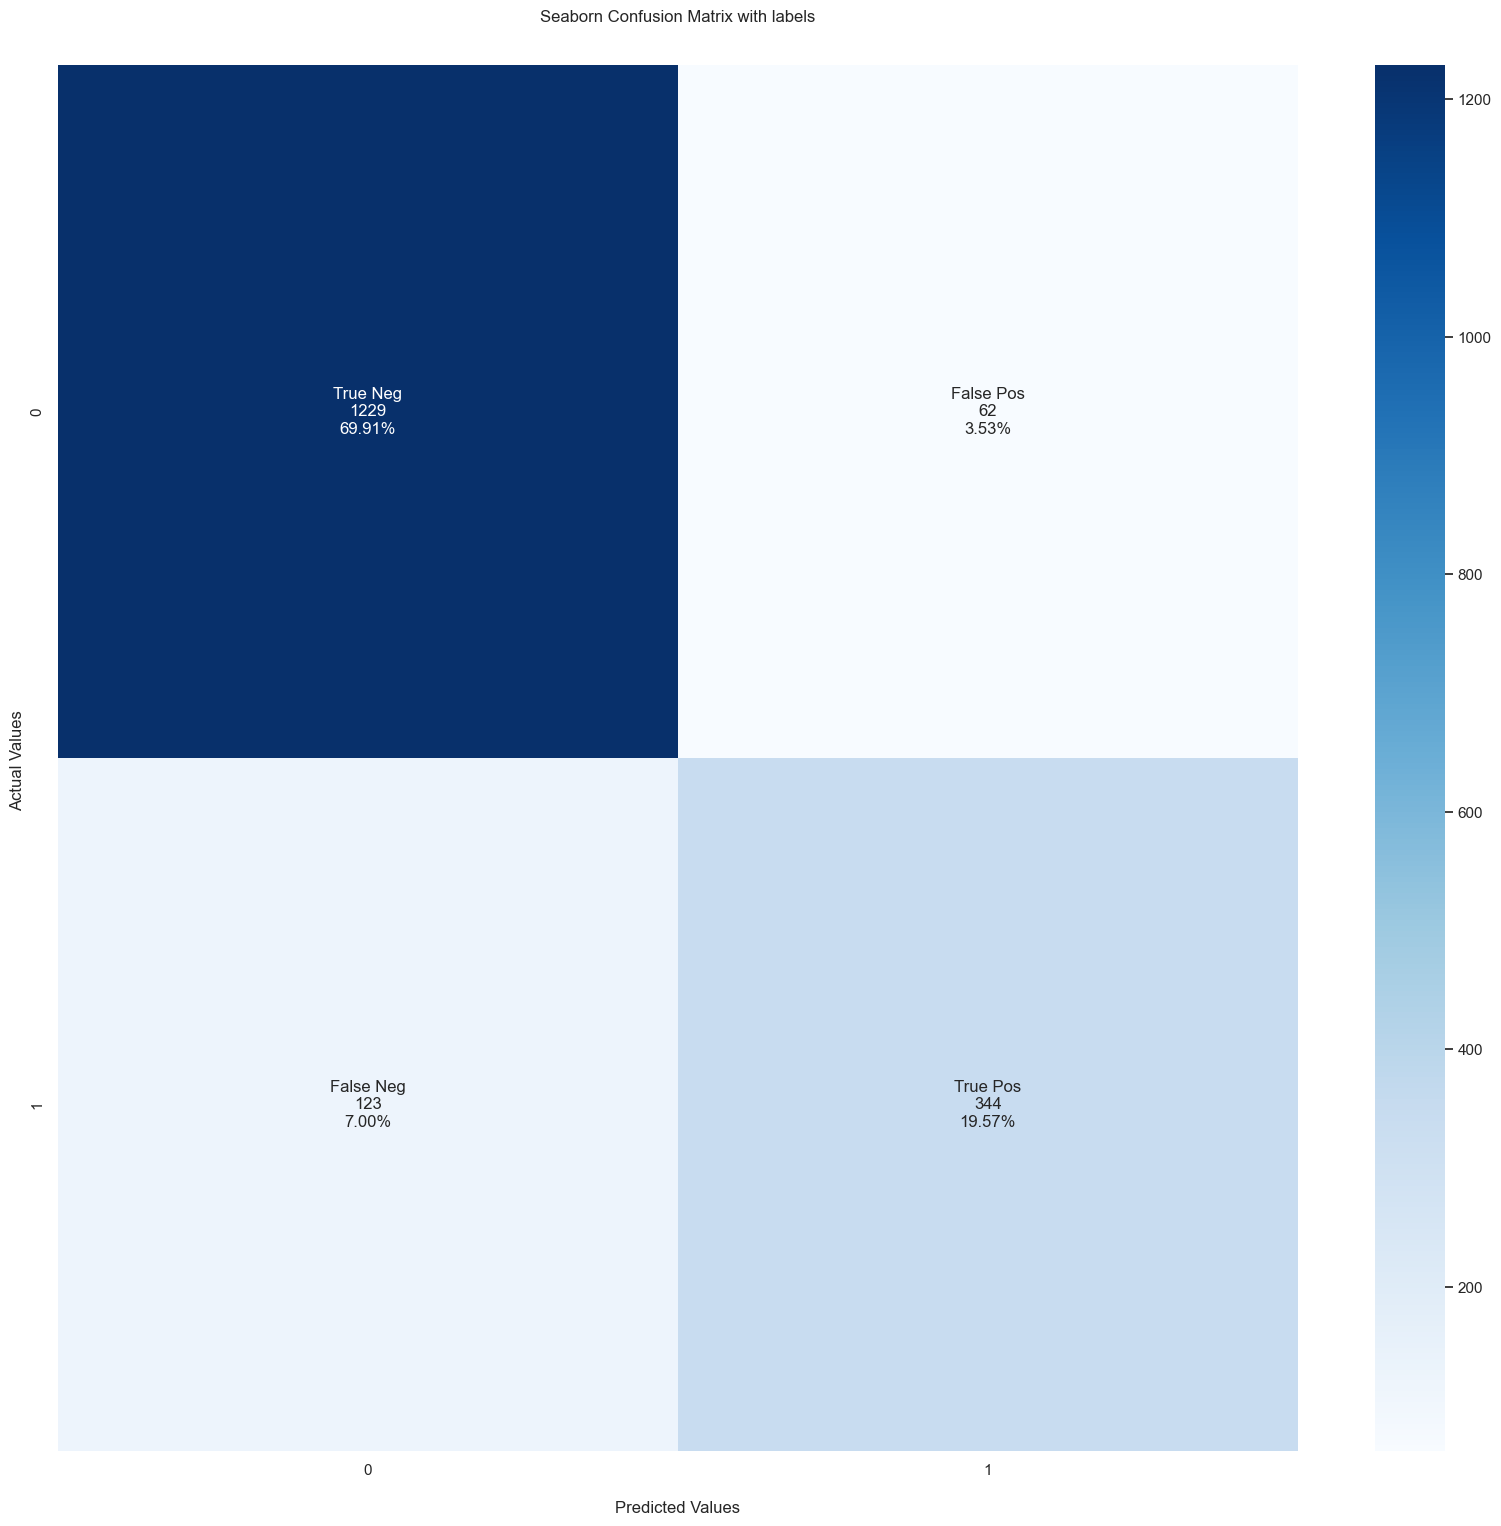

In [37]:
predicted_test = grid_search_cb.predict(features_test)

cf_matrix = confusion_matrix(target_test, predicted_test)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

print('Accuracy:',accuracy_score(target_test, predicted_test))
print('Precision:',precision_score(target_test, predicted_test, pos_label='1'))
print('Recall:',recall_score(target_test, predicted_test, pos_label='1'))


Accuracy metric is quite high -0,89, but taking into account class imbalance in the target feature, this metric is not that useful. Precision and recall can help in this situation as they offer more insight into the model’s skill by elaborating its class-wise performance.
Looking at the current situation:
- if false negative outcomes are a lot, we're not giving a discount to potentially leaving customers. The higher recall the less FN predictions.
- if false positive outcomes are a lot, we're givinig a discount to those who didn't want to leave. The higher presition the less FP predictions.

So in case the client wants to retain customers at any cost, the model might be recalculated to obtain higher recall. But if the cost of the strategy which the client wanted to apply to leaving customers is higher than keeping them than the current model fits the situation. 

**Best model comparison with Dummy model**, to be sure it makes predictions not in a random way.

In [38]:
dummy = DummyClassifier(strategy='stratified')
dummy.fit(features_train,target_train)
dummy_predict_proba = dummy.predict_proba(features_test)[:, 1]
dummy_predict = dummy.predict(features_test)

In [39]:
roc_auc_score(target_test, dummy_predict_proba)

0.49559045740814756

In [40]:
accuracy_score(target_test, dummy_predict)

0.6154721274175199

Dummy model metrics are much lower which tells that our model predicts not in a random way.

## Results communication

**What was done**

*Data loading and preliminary data observation* 

- No duplicates were found;
- Missing data was found only in column 'total_charges' which refers to 'newcomers', it was eliminated;
- Data was changed to appropriate type;
- The **target variable** was identified and processed - column **'EndDate'**.

*Data preprocessing and Exploratory data analysis*
- after dataframes merging a new synthetic feature was added **days** - number of days from the beginning of the contract, whereas 'begin_date' and 'end_date' were eliminated to prevent target leakage;
- **class imbalance in a target feature** was detected, which was later considered in data train-test split; 
- strangely, the **data churn is present only for the end of 2019**. Perhaps we received not a full dataset from the client, it's an important point to confirm;
- **a detailed persona of a leaving customer was described**: most probably it'is a single person of any gender without kids (other dependants). He tends to save - financial aspect is very important for him. He doesn't like to have long-term commitment, that's why prefers to choose monthly payment. He prefers electronic bills and uses fiber optic internet connection. Leaving customers don't use additional services except for streaming TV and movies. In general his intention to leave happens in  first 3-4 months.
- **to detect multicollinearity the 𝜙k correlation coefficient** was calculated, it works for both numerical and catergorical variables. Based on the coefficient the following features were removed - 'gender', 'multiple_line' and 'total_charges'.

*Modeling*

- The following models were applied: LogisticRegression(), RandomForestClassifier(), XGBClassifier() and CatBoostClassifier(). Hyperparameters tuning was done applying GridSearchCV or RandomizedSearchCV (to improve search speed);
- ROC-AUC was calculated on a train sample for every model. CatBoostClassifier() model took the lead by a huge margin, its ROC-AUC score is 0.94. Therefore this model was chosen for further analysis.
| Model | ROC-AUC | 
| --- | --- | 
| LogisticRegression() |  0.84 |
| RandomForestClassifier() |  0.85 |
| XGBClassifier() |  0.85 |
| CatBoostClassifier() |  0.94 |
- Features importance analysis showed that the most important feature determining the fact that a client might leave is 'days' - The second important feature is monthly_charges. Another major factor is payment type - monthly or 1-2 year contract. Also the following features can stand out with some level of importance: internet_service, payment_method, online_security, paperless_billing and tech_support. All the rest of the features are not that important;
- ROC-AUC of the final model on the test sample turned out to be 0.945 - what satisfies the client request;
- ROC-AUC curve is close to the top-left corner, which confirms good performance of the final model;
- Final model Accuracy metric is quite high - 0,89, but it's not representative due to class imbalance in the target feature. Based on Precision and Recall metrics, in case the client wants to retain customers at any cost, the model might be recalculated to obtain higher recall. But if the cost of the strategy which the client wanted to apply to leaving customers is higher than keeping them than the current model fits the situation. 
  - Accuracy = 0.89
  - Precision = 0.85
  - Recall = 0.74
- Dummy model metrics are much lower which tells that the final model predicts not in a random way.
    


**Final model**

CatBoostClassifier with the following hyperparameters: 
- random_state=121222
- cat_features=cf
- depth=2
- iterations=600
- l2_leaf_reg=1
- learning_rate=0.6

The following features were used:
- days
- monthly_charges
- type
- internet_service
- payment_method
- streaming_movies
- paperless_billing
- tech_support
- online_security
- streaming_tv
- senior_citizen
- dependents	
- online_backup
- device_protection
- partner

At the beginning they all showed some level of correlation with the target feature, but after analysing feature importance, it can be said that the most relevant feature is an added synthetic one - 'days' and other less relevant are - monthly_charges, type, internet_service, payment_method. Theoreticaly all these relevant features should be enough for the prediction of the customer churn with good precision. 


**Main insights for the client**


- It was detected that the data about leaving customers is present only for last 3 months of 2019, whereas the whole dataset refers to the data starting from 2014. It seems that there's was some issue during data uploading.

- Feature importance analysis confirmed some insigts detected during EDA: the most important feature of the final model is the amount of days from the beginning of the contract and the monthly charges, therefore it's important to pay more attention to the services costs in general and apply some customers retention strategy especially in first 3-4 months. 

- In general most of the features, especially personal information, were not important at all. For the current model it would be enough to consider 'days', 'monthly_charges', 'type' (payment type), 'internet_service', 'payment_method', 'online_security', 'paperless_billing' and 'tech_support'.

- Even though the quality of the final model satisfies client's request, there are some limitations:
1. Based on Precision and Recall metrics, in case the client wants to retain customers at any cost, the model might be recalculated to obtain higher recall. But if the cost of the strategy which the client wanted to apply to leaving customers is higher than keeping them than the current model fits the situation. 
2. Since the main feature is amount of days from the beginning of the contract, here comes the main limitation - the model is built on the data, which refers to the fact that a customer has already left. Therefore if the behaviour of the customers changes due to some retention strategy (a loyalty program, customer support, personalized promos, etc.), the prediction ability of the model will change. So it's better to enrich available data to understand why we had more new clients at some point, why such a big churn happened out of a sudden. For example, some service quality data might benefit to the model potential of churn prediction (connection disruption, contucting technical support, internet speed, etc.)
